## i. Introduction

By: George Kenji Putra

Dataset: **Credit Card Information**

The dataset is taken from Google BigQuery; this dataset summarizes the usage behavior of about 4,500 active credit card holders with odd number customer id during the last 6 months. The dataset has 18 columns, which are: `CUSTID`, `BALANCE`, `BALANCEFREQUENCY`, `PURCHASES`, and many more. For more information, kindly visit [here](https://console.cloud.google.com/bigquery?project=bootcamp-ftds-2023&ws=!1m5!1m4!4m3!1sftds-hacktiv8-project!2sphase1_ftds_005_hck!3scredit-card-information).

Objective: 

The objective of this project is to analyze customer data, apply clustering analysis to identify distinct customer segments, and provide tailored recommendations to the company based on each segment's characteristics. The project aims to improve customer targeting, enhance loyalty, and optimize business strategies for different customer groups. Additionally, the project seeks to explore and implement automated techniques for determining the optimal number of clusters and involve domain experts to provide valuable insights and guidance. The ultimate goal is to enhance the effectiveness of the clustering approach and maximize the benefits for the company and its customers.


## ii. SQL Query

As mention above, the dataset is taken from Google BigQuery platform. Here are the SQL query commands used in order to generate the dataset:

SELECT *

FROM `ftds-hacktiv8-project.phase1_ftds_005_hck.credit-card-information`

WHERE mod(CUST_ID, 2) <> 0

ORDER BY CUST_ID ASC;

After we get the dataset needed, we will do the remaining processes here. The task for this assignment is to predict the `Customer Segmentation` (clustering) for the clients. So, without further ado, let's get started.

## iii. Importing Libraries

In [4]:
# importing libraries to be used

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import phik

from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from feature_engine.outliers import Winsorizer

import warnings
warnings.filterwarnings(action='ignore')

## iv. Data Loading and Overview

### iv.i Data Loading and Its General Information

Here is the detailed information regarding every column in the dataset:

| Feature                        | Description                                                                                                                 |
| ------------------------------ | --------------------------------------------------------------------------------------------------------------------------- |
| `CUSTID`                         | Identification of Credit Card holder (Categorical)                                                                          |
| `BALANCE`                        | Balance amount left in their account to make purchases                                                                      |
| `BALANCEFREQUENCY`               | How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)           |
| `PURCHASES`                      | Amount of purchases made from account                                                                                       |
| `ONEOFFPURCHASES`                | Maximum purchase amount done in one-go                                                                                      |
| `INSTALLMENTSPURCHASES`          | Amount of purchase done in installment                                                                                      |
| `CASHADVANCE`                    | Cash in advance given by the user                                                                                           |
| `PURCHASESFREQUENCY`             | How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased) |
| `ONEOFFPURCHASESFREQUENCY`       | How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)                   |
| `PURCHASESINSTALLMENTSFREQUENCY` | How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)                      |
| `CASHADVANCEFREQUENCY`           | How frequently the cash in advance being paid                                                                               |
| `CASHADVANCETRX`                 | Number of Transactions made with "Cash in Advanced"                                                                         |
| `PURCHASESTRX`                   | Number of purchase transactions made                                                                                        |
| `CREDITLIMIT`                    | Limit of Credit Card for user                                                                                               |
| `PAYMENTS`                       | Amount of Payment done by user                                                                                              |
| `MINIMUM_PAYMENTS`               | Minimum amount of payments made by user                                                                                     |
| `PRCFULLPAYMENT`                 | Percent of full payment paid by user                                                                                        |
| `TENURE`                         | Tenure of credit card service for user                                                                                      |

In [5]:
# loading and assigning the dataset as df, then showing the first 10 data for general overview

df = pd.read_csv('Customer Segmentation - ML.csv')
df.head(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,1,1854.033230,1.000000,1013.50,576.00,437.50,1243.093189,0.500000,0.083333,0.333333,0.083333,5,15,2000.0,654.473825,1524.375697,0.000000,12
1,3,129.836526,0.909091,1433.99,743.99,690.00,0.000000,0.909091,0.454545,0.636364,0.000000,0,19,4000.0,1363.134203,141.648860,0.875000,11
2,5,21.580264,0.909091,284.72,0.00,284.72,0.000000,0.666667,0.000000,0.666667,0.000000,0,16,5000.0,344.161416,155.792859,0.800000,12
3,7,16.379412,0.454545,178.15,0.00,178.15,0.000000,0.250000,0.000000,0.250000,0.000000,0,3,5000.0,229.376368,89.613822,0.181818,12
4,9,686.657879,1.000000,2476.45,1624.50,851.95,253.273353,1.000000,0.750000,1.000000,0.083333,1,35,4000.0,1600.734366,224.265608,0.083333,12
5,11,89.708187,1.000000,1808.60,1808.60,0.00,450.417925,0.916667,0.916667,0.000000,0.166667,3,26,7500.0,1890.186096,139.117341,0.444444,12
6,13,2931.237524,1.000000,150.00,150.00,0.00,1434.135353,0.083333,0.083333,0.000000,0.083333,3,3,3000.0,577.725789,1683.482088,0.000000,12
7,15,5429.372649,1.000000,493.10,0.00,493.10,0.000000,0.500000,0.000000,0.500000,0.000000,0,6,12000.0,1415.589572,1440.327788,0.000000,12
8,17,1381.080028,1.000000,360.00,0.00,360.00,0.000000,0.666667,0.000000,0.666667,0.000000,0,8,1000.0,115.649241,13564.391210,0.000000,12
9,19,237.344299,1.000000,1266.03,170.00,1096.03,0.000000,1.000000,0.083333,1.000000,0.000000,0,46,1800.0,729.118157,189.433393,0.500000,12


In [6]:
# showing the last 10 data to gain more information

df.tail(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
4465,8931,837.631184,1.000000,0.00,0.00,0.00,867.928181,0.000000,0.000000,0.000000,0.083333,1,0,1000.0,47.144400,5413.385529,0.000000,12
4466,8933,125.793836,1.000000,630.00,0.00,630.00,0.000000,1.000000,0.000000,0.916667,0.000000,0,12,1000.0,373.891965,166.265696,0.200000,12
4467,8935,0.000000,0.000000,102.72,0.00,102.72,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,1500.0,0.000000,NaN,0.000000,12
4468,8937,108.889031,1.000000,1145.85,445.85,700.00,0.000000,1.000000,0.916667,0.750000,0.000000,0,22,5000.0,874.238956,179.080958,0.833333,12
4469,8939,106.894095,0.909091,62.73,0.00,62.73,0.000000,0.272727,0.000000,0.181818,0.000000,0,3,5000.0,540.130507,146.069474,0.272727,11
4470,8941,10571.411070,1.000000,7739.48,0.00,7739.48,0.000000,1.000000,0.000000,1.000000,0.000000,0,44,8000.0,2688.447014,76406.207520,0.000000,12
4471,8943,2584.317807,1.000000,0.00,0.00,0.00,6036.492283,0.000000,0.000000,0.000000,0.250000,7,0,3000.0,6024.595066,826.013735,0.181818,12
4472,8945,655.712971,1.000000,264.35,202.80,61.55,0.000000,0.333333,0.083333,0.166667,0.000000,0,6,1500.0,180.129661,295.417192,0.000000,12
4473,8947,6593.820644,1.000000,388.66,388.66,0.00,4621.934580,0.583333,0.583333,0.000000,0.416667,7,7,7000.0,1624.583114,2503.402340,0.000000,12
4474,8949,37.307085,0.833333,363.38,0.00,363.38,36.363896,0.833333,0.000000,0.666667,0.166667,1,6,1200.0,284.093261,92.369903,0.000000,6


In [7]:
# checking general information regarding the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   int64  
 12  PURCHA

From informations above, we know that:

* The dataset has 4,475 entries or row.
* The dataset has the total of 18 columns.
* The dataset has two data types within it, which are float (14 columns), and integer (4 columns).
* There are <mark>missing values</mark> in `MINIMUM_PAYMENTS` column.

### iv.ii Checking and Handling Duplicated Rows

In [8]:
# checking duplicated rows in the dataset

df.duplicated().sum()

0

<mark>No duplicates</mark> in this dataset, we can proceed without deleting any data.

### iv.iii Numerical Overview

In [9]:
# numerical overview

num_col = df.describe().columns.tolist()
df[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
CUST_ID,4475.0,4475.000000,2583.931114,1.000000,2238.000000,4475.000000,6712.000000,8949.00000
BALANCE,4475.0,1563.205717,2072.045789,0.000000,124.432849,871.355430,2047.570799,18495.55855
BALANCE_FREQUENCY,4475.0,0.876933,0.238222,0.000000,0.888889,1.000000,1.000000,1.00000
PURCHASES,4475.0,1003.251343,2060.034730,0.000000,39.560000,360.000000,1102.420000,41050.40000
ONEOFF_PURCHASES,4475.0,596.369893,1653.425984,0.000000,0.000000,45.650000,575.220000,40624.06000
INSTALLMENTS_PURCHASES,4475.0,407.110215,880.799744,0.000000,0.000000,88.620000,455.885000,14686.10000
CASH_ADVANCE,4475.0,984.288554,2060.448056,0.000000,0.000000,0.000000,1138.887754,47137.21176
PURCHASES_FREQUENCY,4475.0,0.490579,0.402907,0.000000,0.083333,0.500000,0.916667,1.00000
ONEOFF_PURCHASES_FREQUENCY,4475.0,0.202301,0.298203,0.000000,0.000000,0.083333,0.250000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,4475.0,0.363886,0.397603,0.000000,0.000000,0.166667,0.750000,1.00000


In general, the data distribution of this dataset is <mark>Asymmetrical Distribution</mark> if we compare the mean value with the median (50%) value. And also, there are a lot of outliers here since the difference between the max value and the 3rd (75%) quantile is so big. However, in order to ensure the distribution we have for our dataset, we need to check the skewness value, which we will do in the next section.

### iv.iv Categorical Overview

In [10]:
# categorical overview

cat_col = df.select_dtypes(include=['object']).columns.tolist()

for i in cat_col:
    print(i)
    print()
    print(df[i].value_counts())
    print('-' * 40)

In [11]:
# categorical overview

for i in cat_col:
    print('Column: ',i)
    print('Total unique labels: ', df[i].nunique())
    print('-' * 30)

This dataset does not contain categorical type, hence we can skip this overview.

### iv.v Checking and Handling Redundant Columns (If Needed)

In [12]:
# checking number of unique values in the dataset

df.nunique().sort_values(ascending = False)

CUST_ID                             4475
BALANCE                             4433
PAYMENTS                            4362
MINIMUM_PAYMENTS                    4319
PURCHASES                           3203
INSTALLMENTS_PURCHASES              2292
CASH_ADVANCE                        2169
ONEOFF_PURCHASES                    2093
CREDIT_LIMIT                         158
PURCHASES_TRX                        150
CASH_ADVANCE_TRX                      52
CASH_ADVANCE_FREQUENCY                51
PRC_FULL_PAYMENT                      47
PURCHASES_INSTALLMENTS_FREQUENCY      47
PURCHASES_FREQUENCY                   46
ONEOFF_PURCHASES_FREQUENCY            45
BALANCE_FREQUENCY                     43
TENURE                                 7
dtype: int64

`CUST_ID` is used only for unique records, definitely safe to remove. Hence we will remove it in the next process.

## v. Exploratory Data Analysis (EDA)

In this section, we will explore some of the interesting columns to give us general information about the customers, which are: `BALANCE`, `PURCHASES`, `PURCHASES_FREQUENCY`, `INSTALLMENTS_PURCHASES`, and `PURCHASES_INSTALLMENTS_FREQUENCY`.

### v.i Calculating Correlation for All the Columns

interval columns not set, guessing: ['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,1.000000,0.000000,0.000000,0.000000,0.021559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052607,0.007604,0.000000,0.020353,0.015250,0.000000,0.000000
BALANCE,0.000000,1.000000,0.270560,0.382799,0.353951,0.382767,0.466653,0.132694,0.104262,0.139195,0.464559,0.263084,0.372691,0.630728,0.354780,0.238108,0.317568,0.000000
BALANCE_FREQUENCY,0.000000,0.270560,1.000000,0.011292,0.000000,0.000000,0.000000,0.459893,0.236023,0.350318,0.188585,0.044258,0.109183,0.083223,0.071775,0.000000,0.293308,0.273405
PURCHASES,0.000000,0.382799,0.011292,1.000000,0.977518,0.669893,0.073222,0.188474,0.294582,0.170716,0.000000,0.000000,0.667370,0.660200,0.899558,0.242343,0.140602,0.000000
ONEOFF_PURCHASES,0.021559,0.353951,0.000000,0.977518,1.000000,0.498511,0.000000,0.118793,0.271136,0.079613,0.000000,0.000000,0.604690,0.625410,0.880260,0.230975,0.136899,0.000000
INSTALLMENTS_PURCHASES,0.000000,0.382767,0.000000,0.669893,0.498511,1.000000,0.134027,0.336556,0.251688,0.394674,0.032166,0.067688,0.804876,0.519095,0.503017,0.394233,0.188132,0.055192
CASH_ADVANCE,0.000000,0.466653,0.000000,0.073222,0.000000,0.134027,1.000000,0.098668,0.051953,0.073948,0.417840,0.582943,0.149993,0.354362,0.662429,0.000000,0.085123,0.054800
PURCHASES_FREQUENCY,0.000000,0.132694,0.459893,0.188474,0.118793,0.336556,0.098668,1.000000,0.814912,0.880511,0.385130,0.066497,0.461874,0.082495,0.042019,0.000000,0.358430,0.167717
ONEOFF_PURCHASES_FREQUENCY,0.000000,0.104262,0.236023,0.294582,0.271136,0.251688,0.051953,0.814912,1.000000,0.189534,0.151135,0.032301,0.493562,0.226948,0.178536,0.000000,0.244811,0.156297
PURCHASES_INSTALLMENTS_FREQUENCY,0.000000,0.139195,0.350318,0.170716,0.079613,0.394674,0.073948,0.880511,0.189534,1.000000,0.300136,0.069913,0.437366,0.054131,0.045583,0.000000,0.312856,0.220765


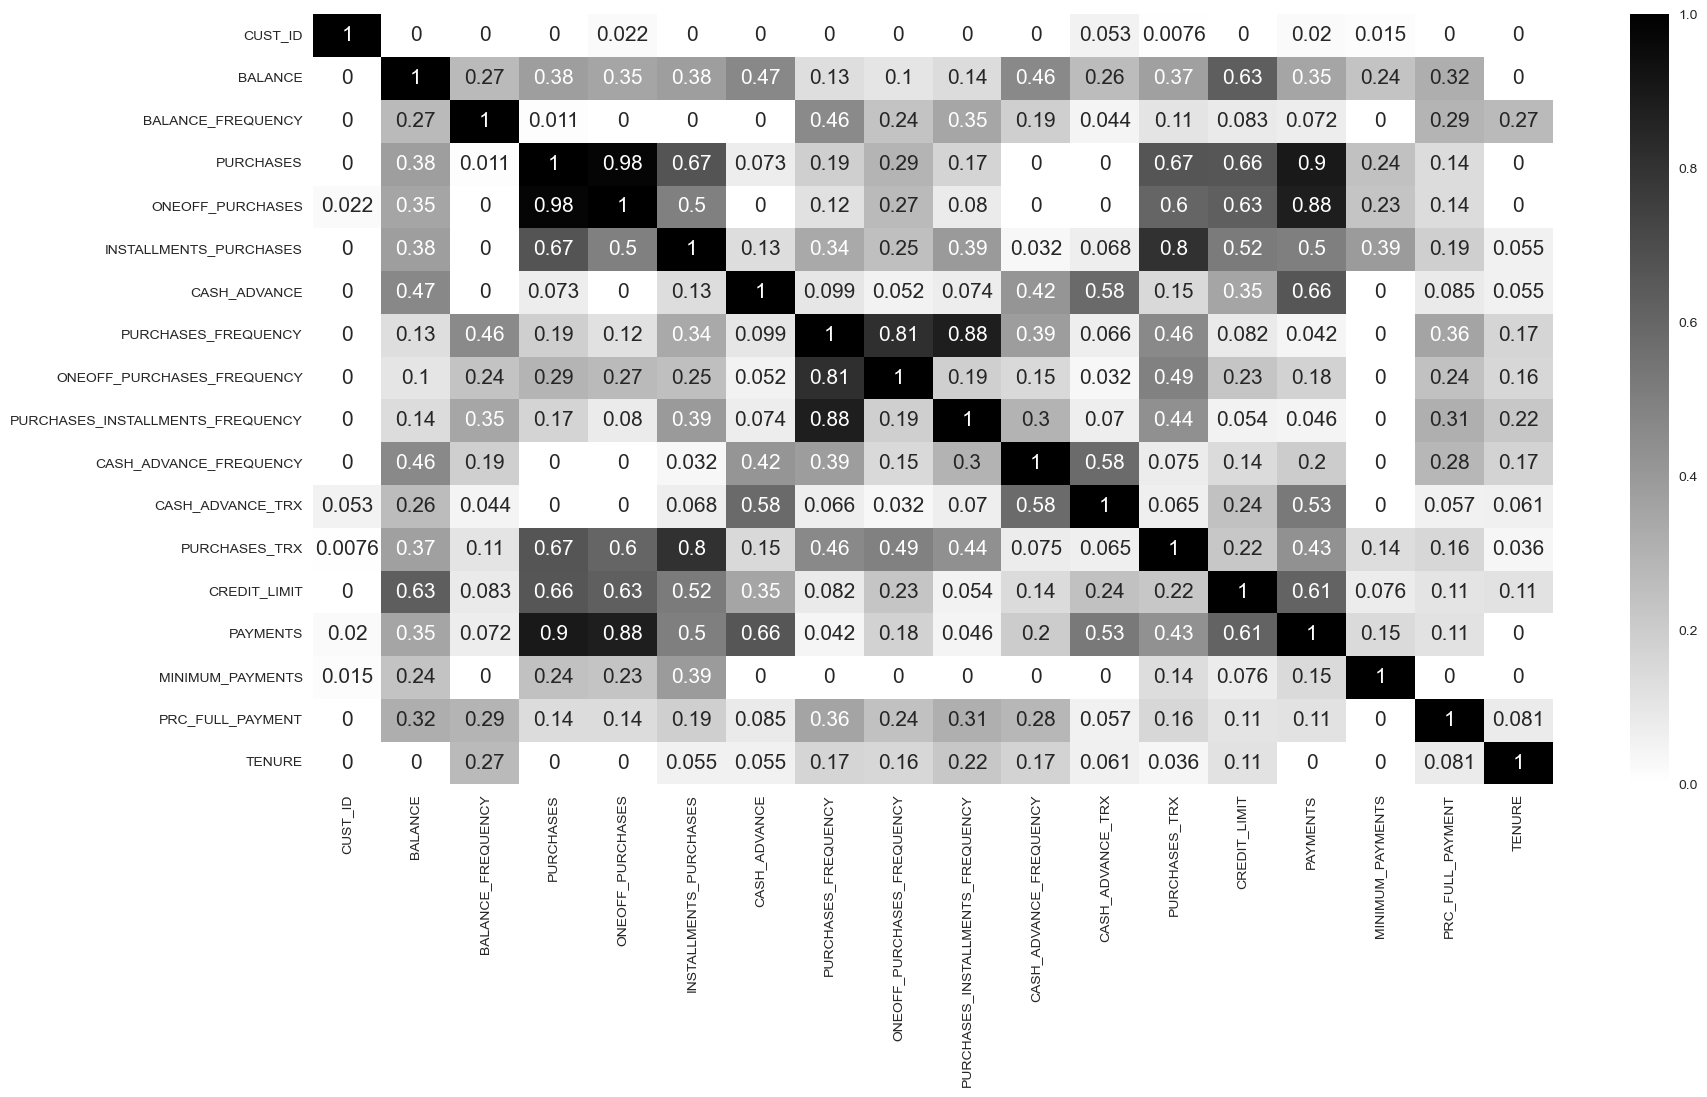

In [13]:
# calculating correlation for the dataset

cor_tbl = df.phik_matrix()

# showing heat map for the correlation table

plt.figure(figsize=(20,10))
sns.heatmap(cor_tbl, annot = True, cmap = 'binary', cbar = True, annot_kws = {'size': 15})
sns.set(font_scale=1);

cor_tbl.head(20)

We have identified the presence of <mark>correlated features</mark> within our dataset. To address this issue, we will apply appropriate techniques for handling correlated data. In this context, we have decided to utilize dimensionality reduction as a means to reduce the number of features and bring our data to a lower-dimensional space. Specifically, we will apply <mark>Principal Component Analysis (PCA)</mark> as our chosen method for dimensionality reduction in the upcoming sections.

### v.ii Balance

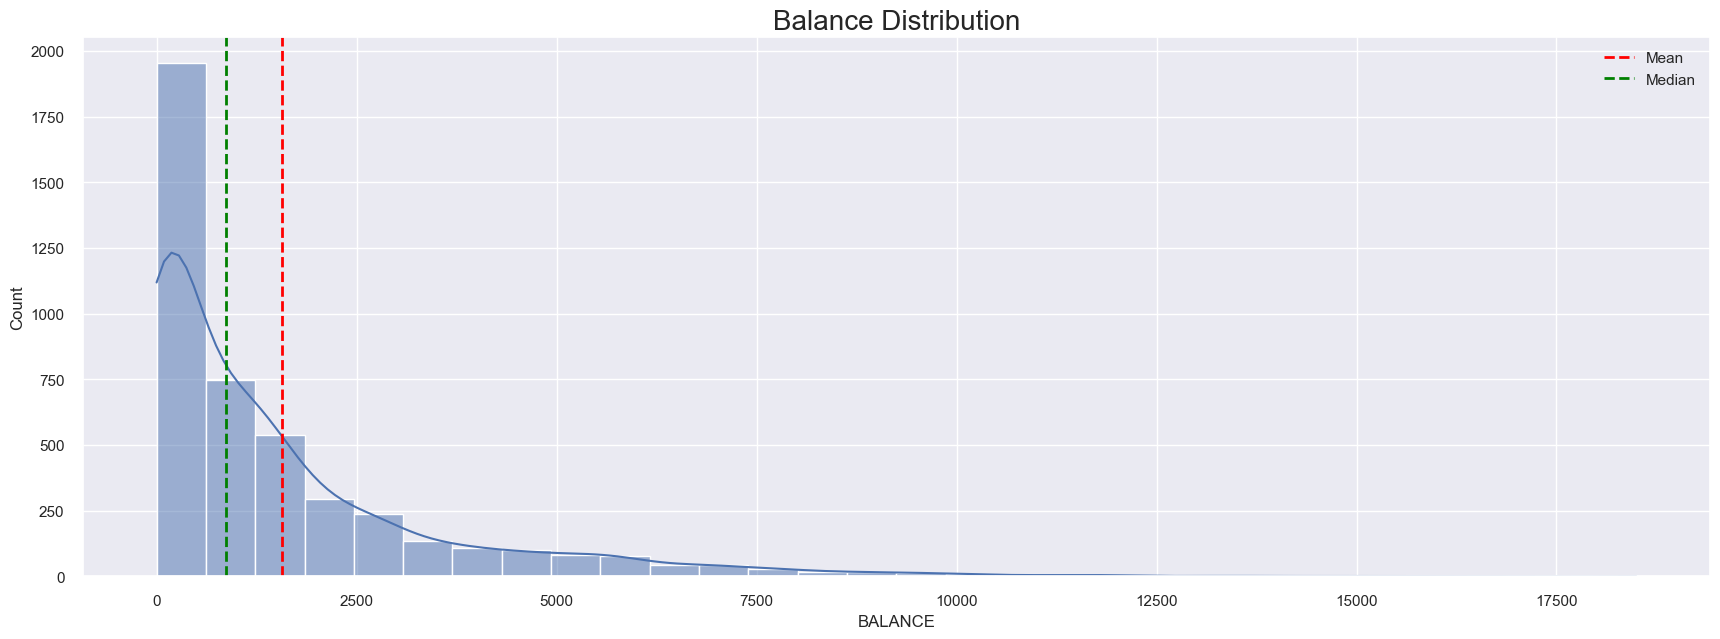

The skewness value of balance column is: 2.329
The mean value of balance column is: 1563.206
The median value of balance column is: 871.35543


In [ ]:
# plot of balance distribution

plt.figure(figsize = (21, 7))
plt.title('Balance Distribution', fontsize = 20)
sns.histplot(df.BALANCE, kde=True, bins=30)
plt.axvline(df.BALANCE.mean(), color = 'red', linestyle='dashed', linewidth = 2, label = 'Mean')
plt.axvline(df.BALANCE.median(), color = 'green', linestyle='dashed', linewidth = 2, label = 'Median')
plt.legend()

plt.show()

# checking skewness, mean, and median values

print('The skewness value of balance column is:', df.BALANCE.skew().round(3))
print('The mean value of balance column is:', df.BALANCE.mean().round(3))
print('The median value of balance column is:', df.BALANCE.median())

In [ ]:
# showing how many customers that have balance more than 17,500

df[df.BALANCE > 17500]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
995,1991,18495.55855,1.0,5288.28,3657.3,1630.98,0.0,1.0,0.583333,1.0,0.0,0,76,22000.0,4246.168346,4227.08158,0.0,12


The average balance of the customer base is approximately $1,600, signifying the typical value within the dataset. However, it is worth noting that there exists an outlier among the customers whose balance significantly surpasses the average, reaching approximately $18,500.

By evaluating the skewness value of this particular column, we observe that it demonstrates a <mark>high level of skewness</mark>. Consequently, in the subsequent sections, our focus will be on addressing the outliers present within this column through appropriate techniques and methodologies.

### v.iii Purchases

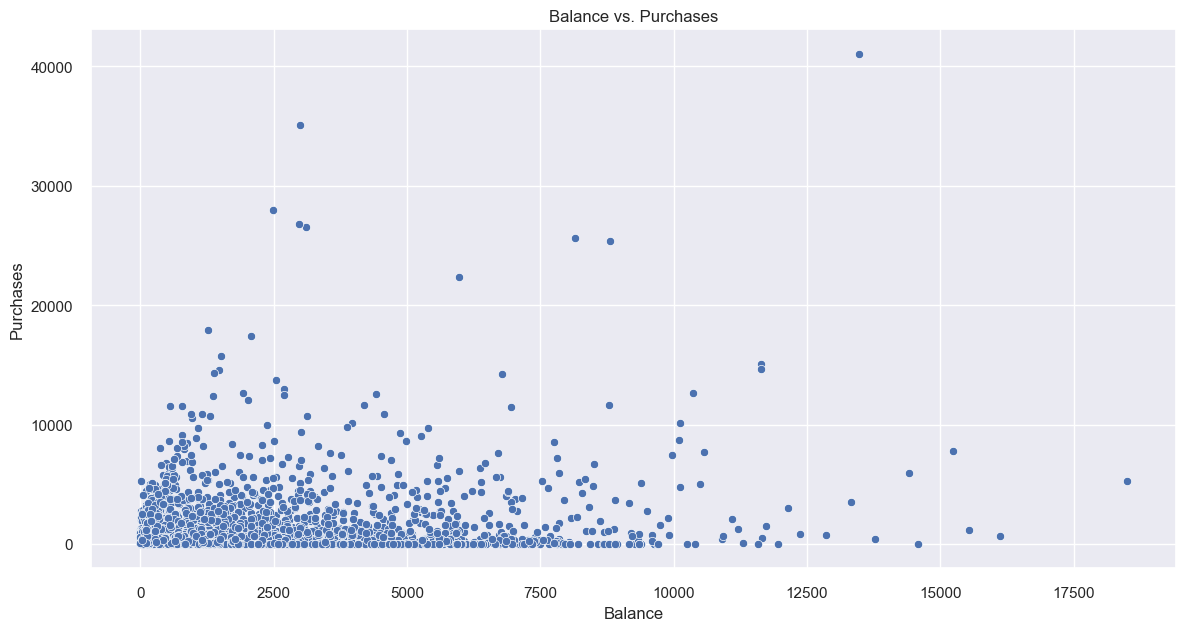

In [ ]:
# scatter plot for balance vs purchase

plt.figure(figsize = (14, 7))
sns.scatterplot(x = 'BALANCE', y = 'PURCHASES', data = df)
plt.title('Balance vs. Purchases')
plt.xlabel('Balance')
plt.ylabel('Purchases')

plt.show()

We have observed a <mark>positive correlation</mark> between the balance and the number of purchases within our dataset. Specifically, it appears that as the <mark>balance increases</mark>, there is a corresponding <mark>increase</mark> in the number of <mark>purchases</mark> made by the customers.

### v.iv Purchases Frequency

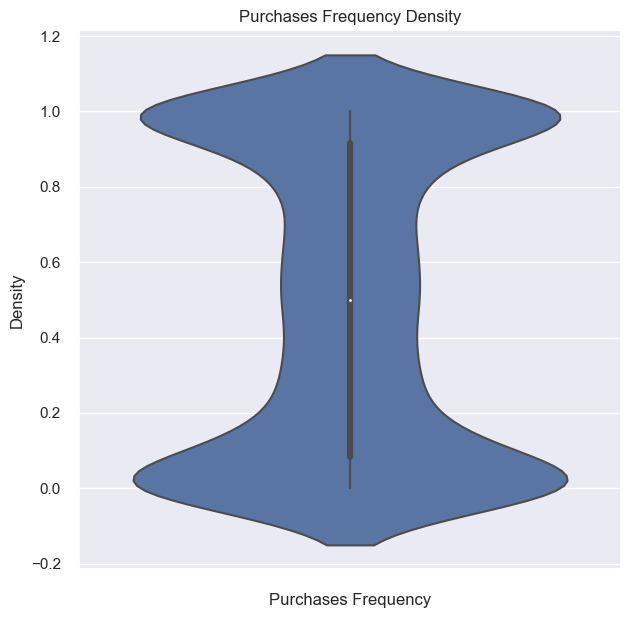

In [ ]:
# violin plot for purchase frequency

plt.figure(figsize = (7, 7))

sns.violinplot(data=df, y='PURCHASES_FREQUENCY')
plt.title('Purchases Frequency Density')
plt.xlabel('Purchases Frequency')
plt.ylabel('Density')

plt.show()

Based on the violin plot, we can see that the data density is <mark>most concentrated</mark> at values 0 and 1, indicating that customers either refrain from making purchases or engage in spending sprees. The similar shape of the violin plot indicates that the median value lies between 0 and 1, specifically at 5, as indicated by the positioning of the small white dot.

Regarding the skewness value, we can determine it by examining the symmetry of the violin plot. In this case, the plot exhibits a symmetrical shape, suggesting a low skewness value. Therefore, the `PURCHASES_FREQUENCY` column follows a symmetrical distribution.

Additionally, <mark>no missing values</mark> have been identified, as there are no data points outside the violin plot.

### v.v Installment Purchases

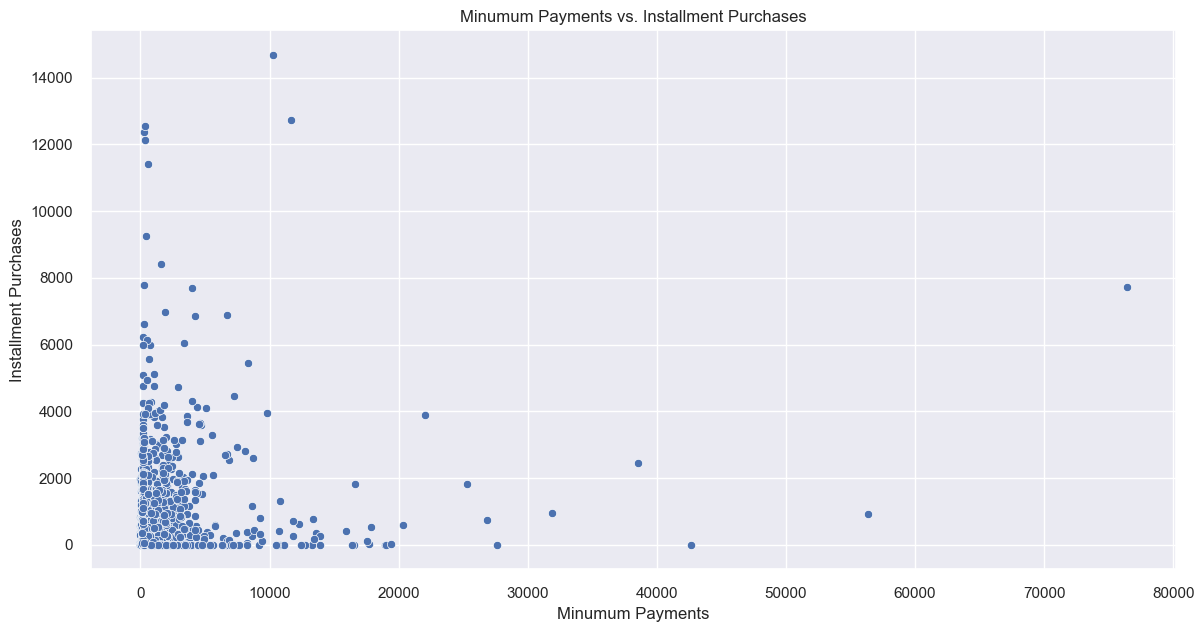

In [ ]:
# scatter plot for minimum payment vs installment purchase

plt.figure(figsize = (14, 7))
sns.scatterplot(x = 'MINIMUM_PAYMENTS', y = 'INSTALLMENTS_PURCHASES', data = df)
plt.title('Minumum Payments vs. Installment Purchases')
plt.xlabel('Minumum Payments')
plt.ylabel('Installment Purchases')

plt.show()

There is a <mark>clear correlation</mark> between `MINIMUM_PAYMENTS` and `INSTALLMENT_PURCHASES`. Customers are more likely to purchase an item on installment if the minimum payment is lower. For example, only four customers have purchased an item on installment with a minimum payment of more than $30,000.

### v.vi Purchases Installment Frequency

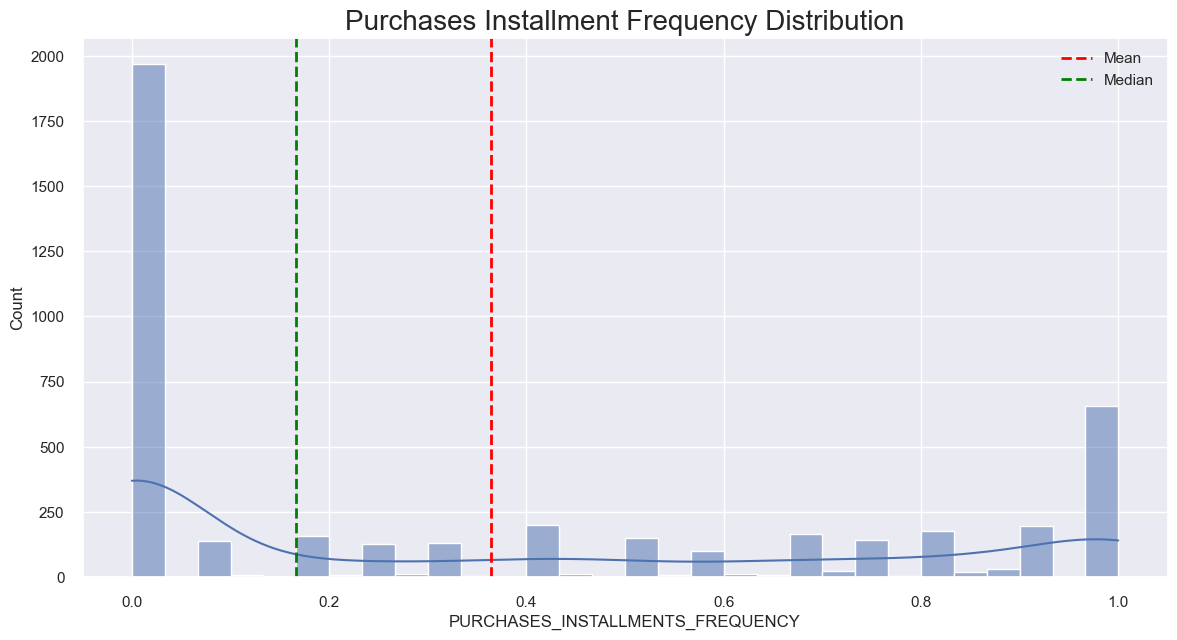

The skewness value of purchases installment frequency column is: 0.508
The mean value of purchases installment frequency column is: 0.364
The median value of purchases installment frequency column is: 0.166667


In [ ]:
# distribution of purchases installment frequency

plt.figure(figsize = (14, 7))
plt.title('Purchases Installment Frequency Distribution', fontsize = 20)
sns.histplot(df.PURCHASES_INSTALLMENTS_FREQUENCY, kde=True, bins=30)
plt.axvline(df.PURCHASES_INSTALLMENTS_FREQUENCY.mean(), color = 'red', linestyle='dashed', linewidth = 2, label = 'Mean')
plt.axvline(df.PURCHASES_INSTALLMENTS_FREQUENCY.median(), color = 'green', linestyle='dashed', linewidth = 2, label = 'Median')
plt.legend()

plt.show()

# checking skewness, mean, and median values

print('The skewness value of purchases installment frequency column is:', df.PURCHASES_INSTALLMENTS_FREQUENCY.skew().round(3))
print('The mean value of purchases installment frequency column is:', df.PURCHASES_INSTALLMENTS_FREQUENCY.mean().round(3))
print('The median value of purchases installment frequency column is:', df.PURCHASES_INSTALLMENTS_FREQUENCY.median())

The skewness value of 0.509 indicates a <mark>moderate positive skewness</mark> in the data distribution. This suggests that there is a slight tendency towards more frequent installment purchases. On average, customers make installment purchases approximately 36.3% of the time. The median value of 0.166667 indicates that 50% of the customers have a purchases installment frequency below or equal to this value. 

The value 0, representing infrequent purchases, has the highest count among the categories, indicating that a significant portion of customers does not frequently opt for installment purchases. The value 1, indicating frequent purchases, follows with the second-highest count. The counts for values between 0 and 1 are relatively low, suggesting that customers generally lean towards either infrequent or frequent installment purchases rather than intermediate frequencies.

### v.vii Data Outliers

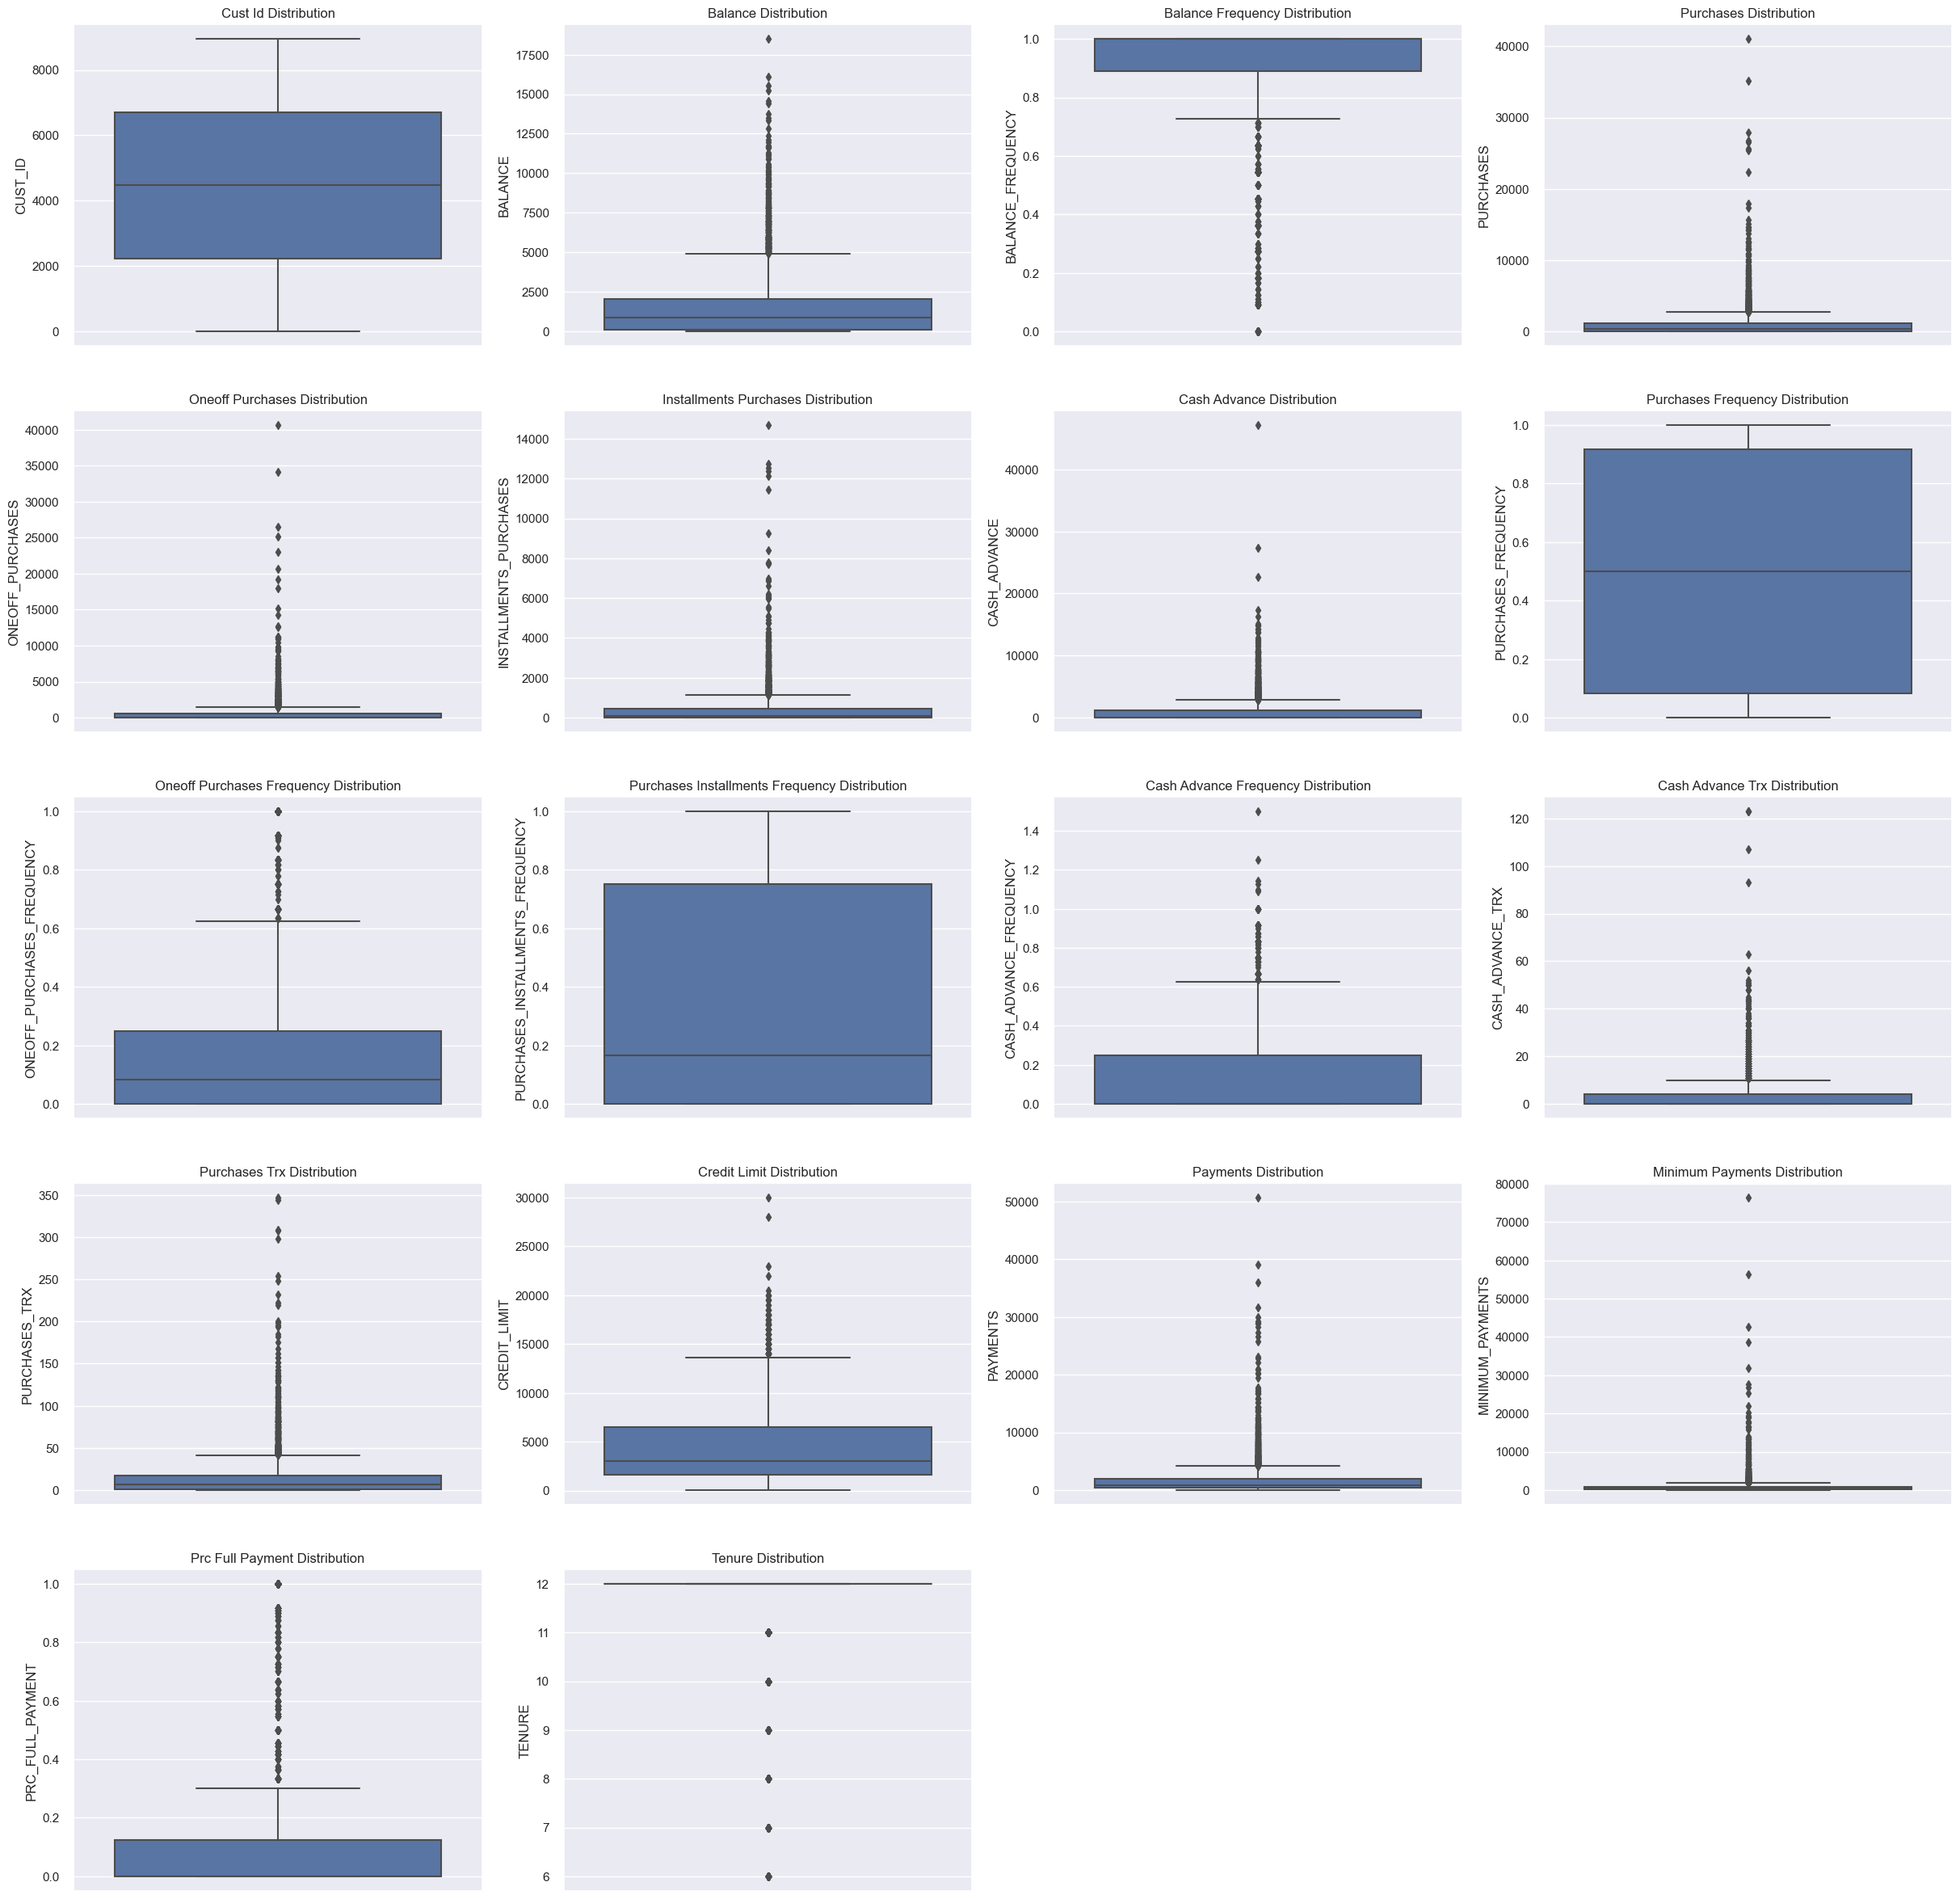

In [ ]:
# showing the box plot for every columns

plt.figure(figsize=(30, 30))
for col in df.columns:
    plt.subplot(5, 4, df.columns.get_loc(col) + 1)
    sns.boxplot(y = col, data = df)
    plt.title(f"{col.replace('_', ' ').title()} Distribution")

plt.show()

Our analysis of the box plots above suggests that there are a large number of outliers in this dataset. Outliers are data points that fall outside the normal range of values. They can be caused by a variety of factors, such as data entry errors, measurement errors, or unusual events. In the next sections, we will investigate the percentage of outliers in this dataset and discuss how to handle them.

## vi. Feature Engineering

### vi.i Saving Inference Data

In this section, we will save 400 sample data from the main dataset. We will use this data for inference process later.

In [ ]:
# saving inference data

inference = df.sample(400, random_state = 42)
inference.to_csv('Customer Segmentation Inference - ML.csv', index=False)

# removing the sample data from the main data

df = df.drop(inference.index)

inference

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
2519,5039,464.674156,0.888889,1979.22,1979.22,0.00,1981.265503,0.666667,0.666667,0.000000,0.111111,1,11,3000.0,3110.052742,132.446091,0.200000,9
2655,5311,133.687510,1.000000,1139.20,0.00,1139.20,0.000000,1.000000,0.000000,0.875000,0.000000,0,15,3000.0,957.152839,116.355394,0.833333,8
2110,4221,1295.446588,1.000000,886.37,886.37,0.00,1310.182842,0.333333,0.333333,0.000000,0.416667,8,7,1800.0,2966.291948,493.349977,0.000000,12
151,303,228.909884,1.000000,2617.85,2426.43,191.42,0.000000,1.000000,0.916667,0.416667,0.000000,0,35,1800.0,1774.318305,143.208454,0.700000,12
4189,8379,1107.099917,1.000000,473.64,0.00,473.64,956.509038,1.000000,0.000000,0.916667,0.083333,1,12,1200.0,501.511019,556.905288,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3554,7109,1358.798385,1.000000,0.00,0.00,0.00,174.369769,0.000000,0.000000,0.000000,0.166667,2,0,1500.0,337.074078,294.178618,0.000000,12
1769,3539,1004.441314,1.000000,530.32,38.00,492.32,0.000000,0.833333,0.083333,0.750000,0.000000,0,14,1000.0,737.914629,1040.035593,0.000000,12
371,743,1839.926709,1.000000,487.75,0.00,487.75,266.614527,0.500000,0.000000,0.416667,0.083333,1,9,3500.0,791.115227,385.482464,0.000000,12
3029,6059,2646.022772,1.000000,1541.13,487.00,1054.13,1234.504809,0.916667,0.250000,0.833333,0.333333,6,17,4000.0,600.203047,575.913224,0.000000,12


### vi.ii Handling the Redundant Column

In the previous section, we identified a redundant column within the dataset. In order to preserve the original data format for future inference purposes, we are going to proceed to drop the redundant column at this stage.

In [ ]:
# handling the redundant column

df_cln = df.drop(['CUST_ID'], axis = 1).reset_index(drop = True)

df_cln

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,1854.033230,1.000000,1013.50,576.00,437.50,1243.093189,0.500000,0.083333,0.333333,0.083333,5,15,2000.0,654.473825,1524.375697,0.000000,12
1,129.836526,0.909091,1433.99,743.99,690.00,0.000000,0.909091,0.454545,0.636364,0.000000,0,19,4000.0,1363.134203,141.648860,0.875000,11
2,21.580264,0.909091,284.72,0.00,284.72,0.000000,0.666667,0.000000,0.666667,0.000000,0,16,5000.0,344.161416,155.792859,0.800000,12
3,16.379412,0.454545,178.15,0.00,178.15,0.000000,0.250000,0.000000,0.250000,0.000000,0,3,5000.0,229.376368,89.613822,0.181818,12
4,686.657879,1.000000,2476.45,1624.50,851.95,253.273353,1.000000,0.750000,1.000000,0.083333,1,35,4000.0,1600.734366,224.265608,0.083333,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4070,106.894095,0.909091,62.73,0.00,62.73,0.000000,0.272727,0.000000,0.181818,0.000000,0,3,5000.0,540.130507,146.069474,0.272727,11
4071,10571.411070,1.000000,7739.48,0.00,7739.48,0.000000,1.000000,0.000000,1.000000,0.000000,0,44,8000.0,2688.447014,76406.207520,0.000000,12
4072,655.712971,1.000000,264.35,202.80,61.55,0.000000,0.333333,0.083333,0.166667,0.000000,0,6,1500.0,180.129661,295.417192,0.000000,12
4073,6593.820644,1.000000,388.66,388.66,0.00,4621.934580,0.583333,0.583333,0.000000,0.416667,7,7,7000.0,1624.583114,2503.402340,0.000000,12


### vi.iii Outlier Percentage

In this section, our objective is to identify outliers present in each column of the dataset. We will adopt a specific approach to handle outliers by <mark>capping</mark> any values that fall below the <mark>20% threshold</mark> of the total data. 

This will be achieved by implementing a pipeline to streamline the outlier detection and capping process. By applying this technique, we aim to mitigate the impact of outliers on our analysis and maintain data integrity within an acceptable range.

In [ ]:
# making function for the outliers detection

def outlier_percent(df_cln):
    Q1 = df_cln.quantile(0.25)
    Q3 = df_cln.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((df_cln < minimum) | (df_cln > maximum))
    num_total = df_cln.count()
    return (num_outliers/num_total)*100

# printing how many percent of outliers in every column

for column in df_cln.columns:
    percent = str(round(outlier_percent(df_cln[column]), 2))
    print(f'Outliers in "{column}": {percent}%')

Outliers in "BALANCE": 8.02%
Outliers in "BALANCE_FREQUENCY": 18.94%
Outliers in "PURCHASES": 9.5%
Outliers in "ONEOFF_PURCHASES": 11.51%
Outliers in "INSTALLMENTS_PURCHASES": 10.06%
Outliers in "CASH_ADVANCE": 11.44%
Outliers in "PURCHASES_FREQUENCY": 0.0%
Outliers in "ONEOFF_PURCHASES_FREQUENCY": 12.32%
Outliers in "PURCHASES_INSTALLMENTS_FREQUENCY": 0.0%
Outliers in "CASH_ADVANCE_FREQUENCY": 3.78%
Outliers in "CASH_ADVANCE_TRX": 9.08%
Outliers in "PURCHASES_TRX": 8.93%
Outliers in "CREDIT_LIMIT": 2.63%
Outliers in "PAYMENTS": 9.18%
Outliers in "MINIMUM_PAYMENTS": 9.62%
Outliers in "PRC_FULL_PAYMENT": 18.04%
Outliers in "TENURE": 15.51%


From the information above, we can say that no column has more than a 20% outlier in its data. Hence, we will cap every column.

### vi.iv Missing Value Detection

In this section, our focus is to identify any missing values present in each column of the dataset. To handle these missing values, we will employ the <mark>KNN imputer</mark> technique within our pipeline. 

The KNN imputer replaces missing values by utilizing the <mark>mean values from the nearest neighbors</mark>, specifically determined by the parameter n_neighbors. By imputing missing values using this approach, we aim to ensure a more complete and reliable dataset for further analysis and modeling.

In [ ]:
# making function for the missing value detection

def mv_percent(df_cln):
    num_mv =  np.sum(df_cln.isnull().sum())
    num_total = df_cln.count()
    return (num_mv/num_total)*100

# printing how many percent of missing value in every column

for column in df_cln.columns:
    percent = str(round(mv_percent(df_cln[column]), 2))
    print(f'Missing Value in "{column}": {percent}%')

Missing Value in "BALANCE": 0.0%
Missing Value in "BALANCE_FREQUENCY": 0.0%
Missing Value in "PURCHASES": 0.0%
Missing Value in "ONEOFF_PURCHASES": 0.0%
Missing Value in "INSTALLMENTS_PURCHASES": 0.0%
Missing Value in "CASH_ADVANCE": 0.0%
Missing Value in "PURCHASES_FREQUENCY": 0.0%
Missing Value in "ONEOFF_PURCHASES_FREQUENCY": 0.0%
Missing Value in "PURCHASES_INSTALLMENTS_FREQUENCY": 0.0%
Missing Value in "CASH_ADVANCE_FREQUENCY": 0.0%
Missing Value in "CASH_ADVANCE_TRX": 0.0%
Missing Value in "PURCHASES_TRX": 0.0%
Missing Value in "CREDIT_LIMIT": 0.0%
Missing Value in "PAYMENTS": 0.0%
Missing Value in "MINIMUM_PAYMENTS": 3.66%
Missing Value in "PRC_FULL_PAYMENT": 0.0%
Missing Value in "TENURE": 0.0%


From the information above, we can understand that only the `MINIMUM_PAYMENTS` column has missing values, which is 3.66% of the total data. Hence, we will impute the missing values in the next process.

### vi.v Scaling Type Detection

In this section, our objective is to examine the distribution of each column within the dataset. By analyzing the distribution, we can determine the most suitable scaler to use for further data processing.

In [ ]:
# checking the skewness value in every column

for skew in df_cln.columns:
    print(f'Skewness value in "{skew}": ', round(df_cln[skew].skew(), 2))

Skewness value in "BALANCE":  2.33
Skewness value in "BALANCE_FREQUENCY":  -2.04
Skewness value in "PURCHASES":  7.27
Skewness value in "ONEOFF_PURCHASES":  10.4
Skewness value in "INSTALLMENTS_PURCHASES":  6.55
Skewness value in "CASH_ADVANCE":  5.73
Skewness value in "PURCHASES_FREQUENCY":  0.06
Skewness value in "ONEOFF_PURCHASES_FREQUENCY":  1.55
Skewness value in "PURCHASES_INSTALLMENTS_FREQUENCY":  0.51
Skewness value in "CASH_ADVANCE_FREQUENCY":  1.83
Skewness value in "CASH_ADVANCE_TRX":  6.56
Skewness value in "PURCHASES_TRX":  4.8
Skewness value in "CREDIT_LIMIT":  1.51
Skewness value in "PAYMENTS":  5.9
Skewness value in "MINIMUM_PAYMENTS":  15.24
Skewness value in "PRC_FULL_PAYMENT":  2.01
Skewness value in "TENURE":  -2.97


It shown that most the columns are highly skewed, only `PURCHASES_FREQUENCY` and `PURCHASES_INSTALLMENTS_FREQUENCY` that have a decent skewness value. Hence, we will use <mark>PowerTransformer</mark> for our scaler.

### vi.vi Dimention Reduction with Principal Component Analysis (PCA)

In the context of utilizing K-means for clustering, it is important to address the issue of increased dimensions and the potential loss of meaning associated with Euclidean distance calculations. To mitigate this problem, it becomes necessary to reduce the number of dimensions in the dataset. 

In this scenario, we employ Principal Component Analysis (PCA) as a dimensionality reduction technique. By setting the parameter n_components to 0.9, we instruct PCA to automatically generate a sufficient number of Principal Components (PCs) that preserve 90% of the variance present in the dataset. This ensures that we retain the majority of the important information while reducing the dimensionality of the data.

By incorporating this step into our pipeline, we can effectively address the challenges posed by high-dimensional data and subsequently proceed with the clustering process using K-means algorithm.

### vi.vii Making Pipeline

This is an attempt to make a pipeline in order to save a lot of time and effort. Automation is beautiful!

In [ ]:
# defining X

X = df_cln.copy()

In [ ]:
# pipeline for every columns except TENURE

num_1_pipeline = Pipeline([
        ('imputer', KNNImputer()),
        ('outlier', Winsorizer(capping_method='iqr', tail='both', fold=1.5)),
        ('scaler', PowerTransformer()),
        ('pca', PCA(n_components=.9, random_state = 42))
    ])

num_1_tr = num_1_pipeline.fit_transform(X[['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'ONEOFF_PURCHASES_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY']])

In [ ]:
# pipeline for TENURE columns, because the variance is too low to use iqr method

num_2_pipeline = Pipeline([
        ('imputer', KNNImputer()),
        ('outlier', Winsorizer(capping_method='quantiles', tail='both', fold=0.15)),
        ('scaler', PowerTransformer()),
        ('pca', PCA(n_components=.9, random_state = 42))
    ])

num_2_tr = num_2_pipeline.fit_transform(X[['TENURE']])

In [ ]:
# combining all preprocessing pipelines into one

preprocess = ColumnTransformer([
        ("num_1", num_1_pipeline, ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
                                    'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'ONEOFF_PURCHASES_FREQUENCY',
                                    'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
                                    'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
                                    'PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY']),
        ("num_2", num_2_pipeline, ['TENURE'])
    ])

X_final = preprocess.fit_transform(X)

In [ ]:
# showing the result of preprocess for X

X_final

array([[-0.01120157, -2.0422436 , -0.71735882, ...,  1.34611878,
        -0.20979096, -0.42844002],
       [ 3.50769824,  0.45956699,  0.86328731, ...,  0.11854376,
         0.00827295,  2.33404902],
       [ 1.96032488,  2.34379098, -1.1594159 , ..., -0.83466837,
        -0.35049703, -0.42844002],
       ...,
       [ 0.67520695,  1.02190657,  0.41915017, ...,  0.43298775,
         0.3115871 , -0.42844002],
       [-1.61222321, -3.54452572,  1.29484558, ...,  0.53218636,
        -0.08239422, -0.42844002],
       [ 0.31943494,  1.83629404, -1.71798904, ...,  1.7768394 ,
        -1.39002175,  2.33404902]])

In [ ]:
# convert to dataframe

X_final = pd.DataFrame(X_final, columns=['PCA_' + str(i) for i in range(1, 8)])

X_final

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7
0,-0.011202,-2.042244,-0.717359,-0.711881,1.346119,-0.209791,-0.428440
1,3.507698,0.459567,0.863287,1.299377,0.118544,0.008273,2.334049
2,1.960325,2.343791,-1.159416,1.126466,-0.834668,-0.350497,-0.428440
3,0.771084,3.256007,-0.218299,1.211021,-0.997784,-0.698264,-0.428440
4,2.740160,-1.939746,-0.037572,1.029889,1.239332,0.312269,-0.428440
...,...,...,...,...,...,...,...
4070,0.399078,2.614532,-0.208388,0.969088,-1.480719,0.090510,2.334049
4071,2.297905,-1.914450,-2.175530,-1.275696,-2.097802,-0.721618,-0.428440
4072,0.675207,1.021907,0.419150,-1.958853,0.432988,0.311587,-0.428440
4073,-1.612223,-3.544526,1.294846,-0.117802,0.532186,-0.082394,-0.428440


## vii. Model Definition

In this assignment, we are tasked to make the models using <mark>K- Means</mark>. Before we define the model, we need to find the <mark>best K value</mark> for our model.

### vii.i Finding the Right K Value with Elbow Method

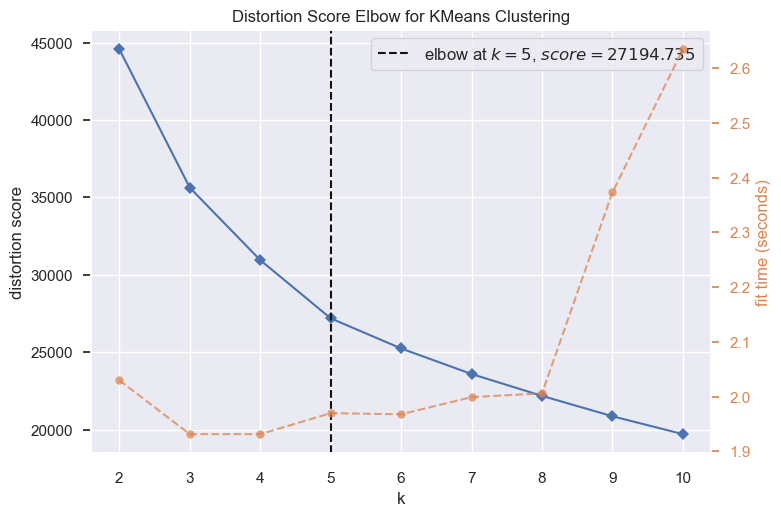

In [ ]:
# finding the best K value with elbow method

distortion_visualizer = KElbowVisualizer(KMeans(random_state=42, init = 'k-means++', max_iter = 500, n_init = 20), k=(2,11))

distortion_visualizer.fit(X_final)
distortion_visualizer.show();

Based on the elbow method plot, it appears that the optimal value for <mark>k is 5</mark>. However, it is essential to ><mark>validate</mark> this finding using <mark>additional methods</mark> to ensure its accuracy and reliability. Two commonly used techniques for assessing clustering quality are the <mark>Silhouette Score</mark> and <mark>Davies-Bouldin Index (DBI)</mark>.

### vii.ii Finding the Right K Value with Silhouette Score and Davies Bouldin Index

In [ ]:
# finding the best k value with silhouette score and davies bouldin index

kmeans_score = pd.DataFrame(columns=['K', 'Silhouette Score', 'DBI'])

for i in range(2, 11):
    kmeans_score.loc[i-2] = [i, 
                             round(silhouette_score(X_final, KMeans(n_clusters = i, init = 'k-means++', max_iter = 500, n_init = 20, random_state=42).fit(X_final).labels_), 3),
                             round(davies_bouldin_score(X_final, KMeans(n_clusters = i, init = 'k-means++', max_iter = 500, n_init = 20, random_state=42).fit(X_final).labels_), 3)]
    
kmeans_score.sort_values(by='Silhouette Score', ascending=False)

,K,Silhouette Score,DBI
0,2.0,0.285,1.377
3,5.0,0.274,1.338
1,3.0,0.265,1.476
2,4.0,0.260,1.458
6,8.0,0.240,1.461
8,10.0,0.234,1.424
4,6.0,0.233,1.477
5,7.0,0.227,1.454
7,9.0,0.226,1.463


* **Silhouette Score**

The Silhouette Score measures the <mark>compactness</mark> of clusters and the <mark>separation</mark> between clusters. It ranges from -1 to 1, where <mark>higher</mark> values indicate <mark>better-defined and well-separated clusters</mark>. The best score we have here is when the k = 2, while the previous method suggested us k = 5. Silhouette Score below 0.3 suggests that the clusters have a moderate level of separation and some overlapping or ambiguity between them.

* **Davies-Bouldin Index**

The Davies-Bouldin Index measures the <mark>average similarity</mark> between clusters and the <mark>dissimilarity</mark> between clusters. <mark>Lower values indicate better clustering results, with well-separated and distinct clusters</mark>. In this case, our best DBI appears when the k = 5, with the score of 1.338. While k = 2 has a score of 1.377, both numbers suggest a moderate level of separation between the clusters.

Considering these scores, all the k values suggested will produce a <mark>moderate result</mark>. However, moderate clustering performance may still be <mark>acceptable</mark> and <mark>provide meaningful insights</mark>.

Next, we will check the silhouette plot that shows each data point's silhouette coefficient value and cluster assignment.

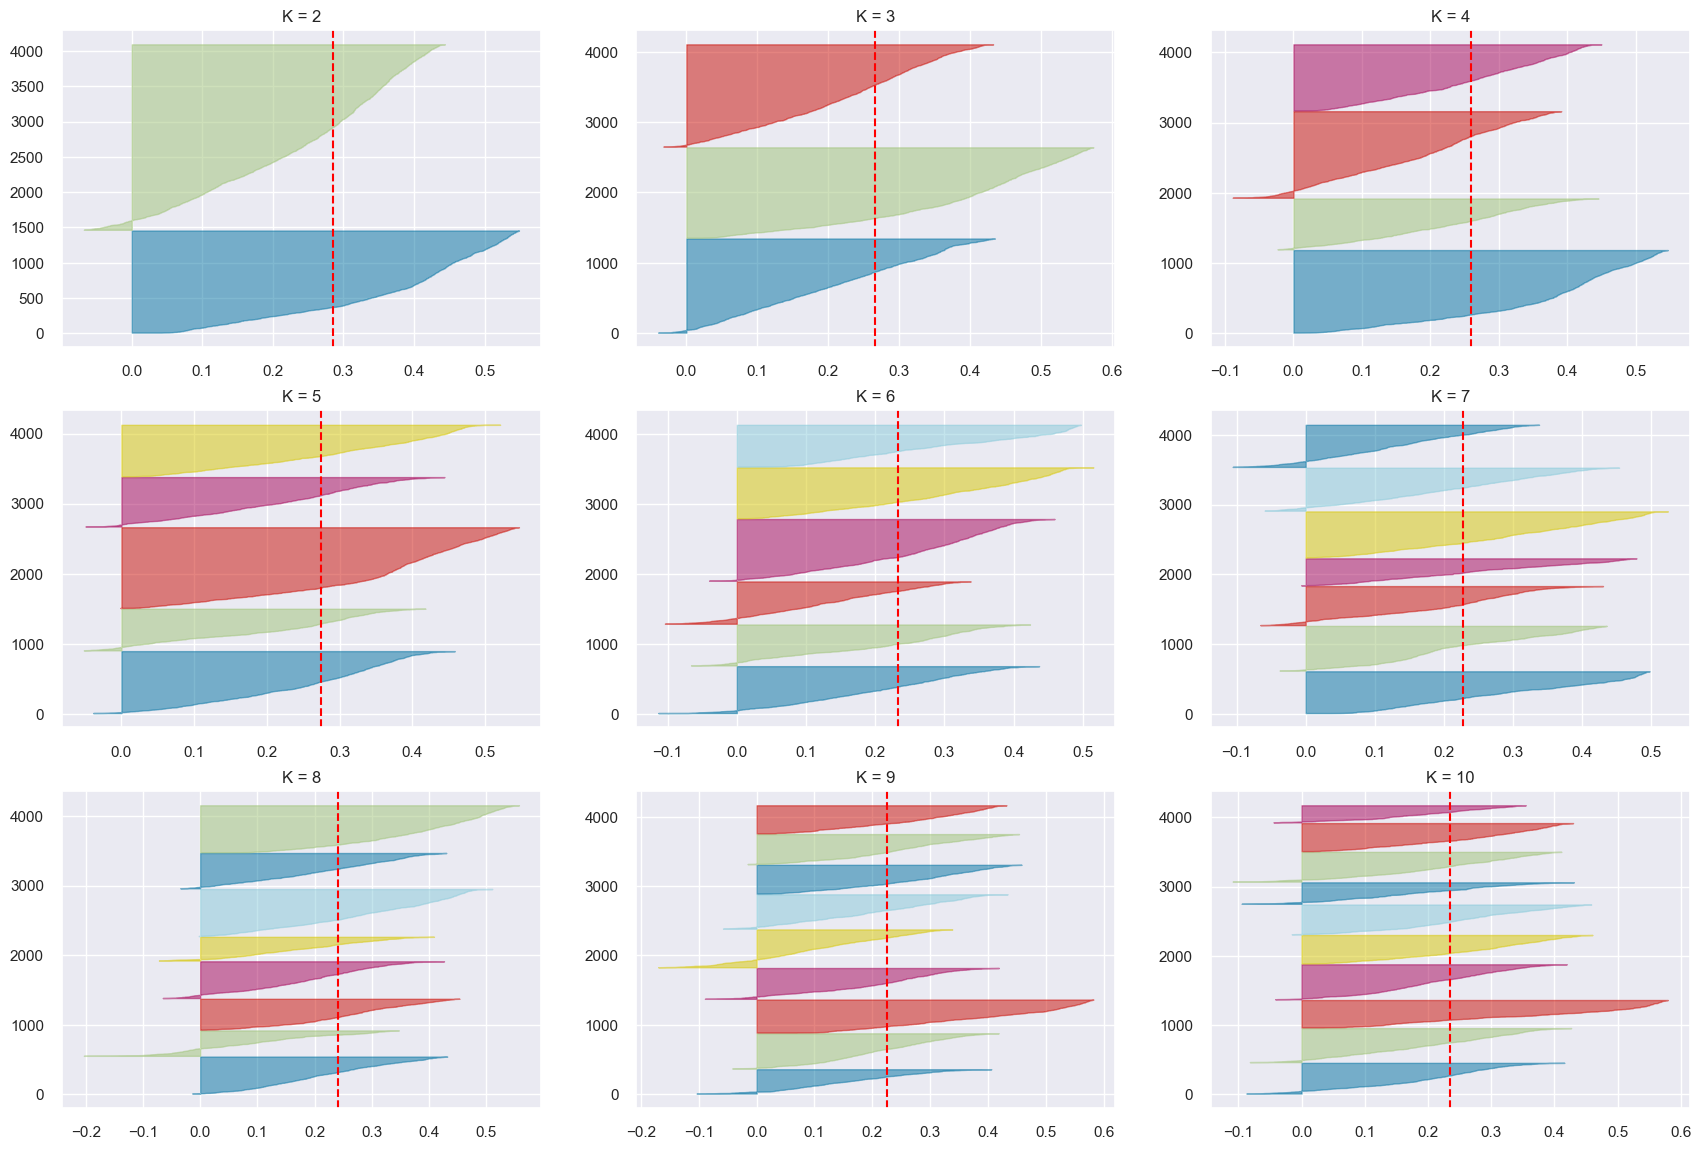

In [ ]:
# set up subplots for every silhouette plots

fig, axes = plt.subplots(3, 3, figsize=(21, 14))

# loop for every subplot

for i, ax in enumerate(axes.flatten()):
    n_clusters = i + 2
    km1 = KMeans(n_clusters=n_clusters, init="k-means++", n_init = 20, max_iter = 500, random_state = 42)
    visualizer = SilhouetteVisualizer(km1, colors='yellowbrick', ax=ax)
    visualizer.fit(X_final)
    ax.set_title(f'K = {n_clusters}')

plt.show()

Based on the silhouette plots for each cluster, our primary focus was on evaluating the clusters formed with k values of 2 and 5, as these were suggested by previous methods. However, we also considered k = 3 due to its potential advantages compared to other values.

If we see, all the shades passed the average line, it indicates that the every cluster's average silhouette score is higher than the overall average silhouette score for all data points. This suggests that the cluster is relatively well-separated and has a higher degree of cohesion compared to the average cluster.

If we compare to the rest of the plots, k = 3 has the smalles shade of negative value. Negative value indicate potential issues with cluster separation and the possibility of misassigned data points. Means that, the misassigned possibility when the k = 3 is the smallest among the others.

After careful consideration of all the relevant factors, we can confidently conclude that the <mark>best k value</mark> for this particular case is <mark>3</mark>. It is important to note that while the silhouette score for k = 3 ranks third, the <mark>difference between the top-ranking score and the score for k = 3 is relatively small</mark>. Therefore, considering the overall performance and characteristics of the clusters, k = 3 emerges as the most suitable choice.

By taking into account the insights gained from the silhouette plots and considering the additional evaluation metrics, we have reached a robust conclusion regarding the optimal number of clusters for our analysis.

## viii. Model Training

Overall, training a machine learning model aims to achieve these purposes by developing a model that can generalize well, make accurate predictions or classifications, and enable data-driven decision-making in various domains and applications.

In [ ]:
# defining the model

km = KMeans(n_clusters=3, init="k-means++", n_init = 20, max_iter = 500, random_state = 42)

In [ ]:
# training the model with KMeans

km.fit(X_final)

KMeans(max_iter=500, n_clusters=3, n_init=20, random_state=42)

## ix. Model Evaluation

### ix.i Predicting the Model

In [ ]:
# predict with KMeans

y_pred = km.fit_predict(X_final)

y_pred

array([0, 2, 2, ..., 2, 0, 2])

In [ ]:
# checking on which iteration the model reach convergence

km.n_iter_

9

Convergence in the context of machine learning refers to the state when an iterative algorithm has reached a stable or optimal solution. It signifies that the algorithm has completed its learning process and has achieved a satisfactory outcome based on certain predefined criteria.

In the specific case mentioned, after conducting nine trials, the algorithm has reached the optimal solution. Repeating the algorithm would likely have minimal or negligible impact on the results obtained. This suggests that the algorithm has already converged to a stable state, and further iterations are unlikely to yield significantly different outcomes.

In [ ]:
# adding the predict result to the X_final (principal columns)

X_final['Cluster'] = list(y_pred)
X_final.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,Cluster
0,-0.011202,-2.042244,-0.717359,-0.711881,1.346119,-0.209791,-0.428440,0
1,3.507698,0.459567,0.863287,1.299377,0.118544,0.008273,2.334049,2
2,1.960325,2.343791,-1.159416,1.126466,-0.834668,-0.350497,-0.428440,2
3,0.771084,3.256007,-0.218299,1.211021,-0.997784,-0.698264,-0.428440,2
4,2.740160,-1.939746,-0.037572,1.029889,1.239332,0.312269,-0.428440,0


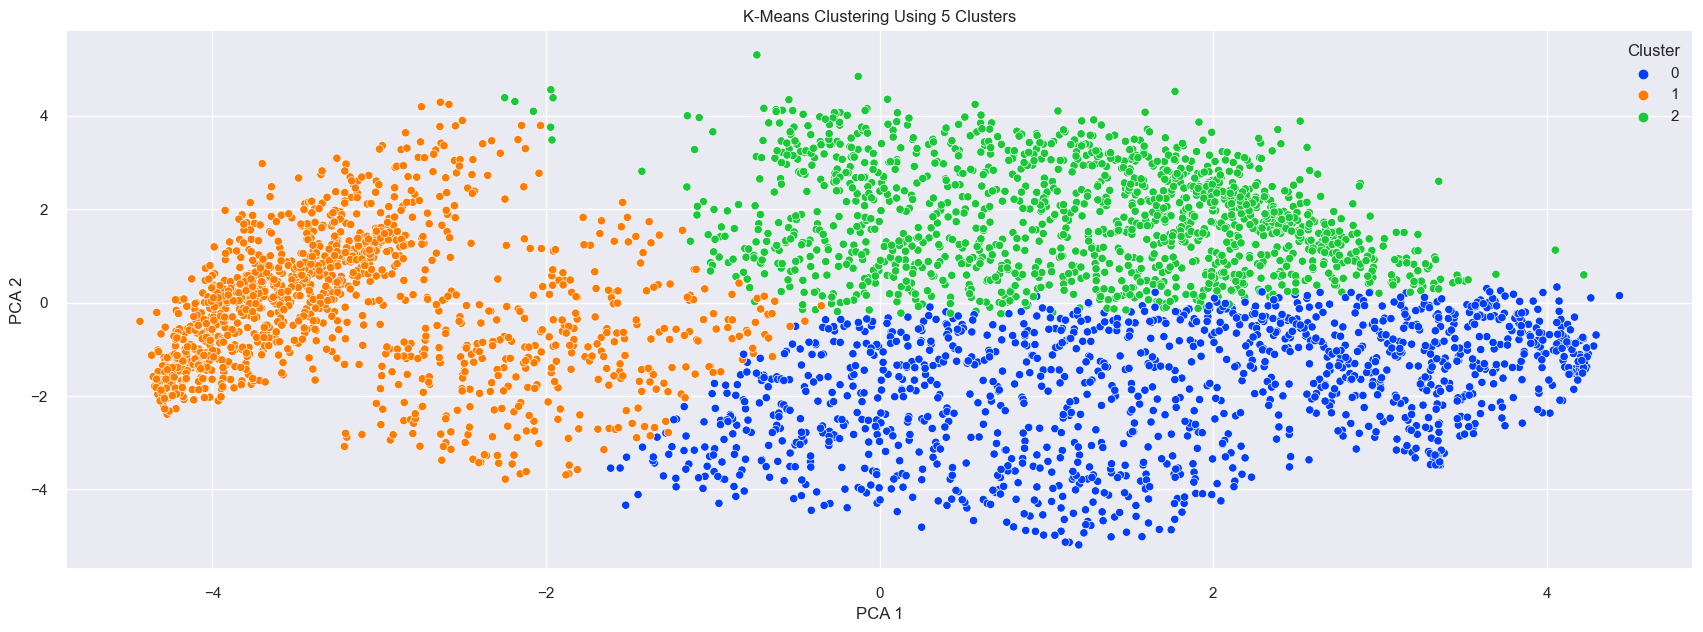

In [ ]:
# showing the clustering result by scatter plot

plt.figure(figsize=(21, 7))
sns.scatterplot(x='PCA_1', y='PCA_2', hue='Cluster', data=X_final, palette='bright')
plt.title('K-Means Clustering Using 5 Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

### ix.ii Model Analisys

To achieve optimal clustering results, it is essential to determine the appropriate number of clusters for the given dataset. Several methods were employed to ascertain the ideal k-value (cluster count), namely the <mark>elbow method, silhouette score method, and Davies-Bouldin index method</mark>.

According to the elbow method, the recommended k-value is 5, as the decline in distortion score diminishes significantly beyond this point. Conversely, both the silhouette score method and the Davies-Bouldin index method indicate a preferable k-value of 2. Analyzing the silhouette plot of all clusters, it is evident that <mark>k = 3 is the most suitable choice</mark>. 

Although the silhouette score for <mark>k = 3 ranks third, the discrepancy between the top-ranking score and the score for k = 3 is relatively marginal</mark>. Notably, <mark>k = 3 exhibits the least negative value among the plots</mark>, indicating better cluster separation and minimized potential for data point misassignments. Therefore, considering the overall performance and cluster characteristics, k = 3 emerges as the optimal selection.

The model achieved convergence after nine iterations. Finally, the cluster divisions are appropriately delineated in the plot, without any apparent misassigned customer segments.

### ix.iii Cluster Analisys

In [ ]:
# adding the predicted results with the original data

df_cln['Cluster'] = list(y_pred)
df_cln.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Cluster
0,1854.033230,1.000000,1013.50,576.00,437.50,1243.093189,0.500000,0.083333,0.333333,0.083333,5,15,2000.0,654.473825,1524.375697,0.000000,12,0
1,129.836526,0.909091,1433.99,743.99,690.00,0.000000,0.909091,0.454545,0.636364,0.000000,0,19,4000.0,1363.134203,141.648860,0.875000,11,2
2,21.580264,0.909091,284.72,0.00,284.72,0.000000,0.666667,0.000000,0.666667,0.000000,0,16,5000.0,344.161416,155.792859,0.800000,12,2
3,16.379412,0.454545,178.15,0.00,178.15,0.000000,0.250000,0.000000,0.250000,0.000000,0,3,5000.0,229.376368,89.613822,0.181818,12,2
4,686.657879,1.000000,2476.45,1624.50,851.95,253.273353,1.000000,0.750000,1.000000,0.083333,1,35,4000.0,1600.734366,224.265608,0.083333,12,0


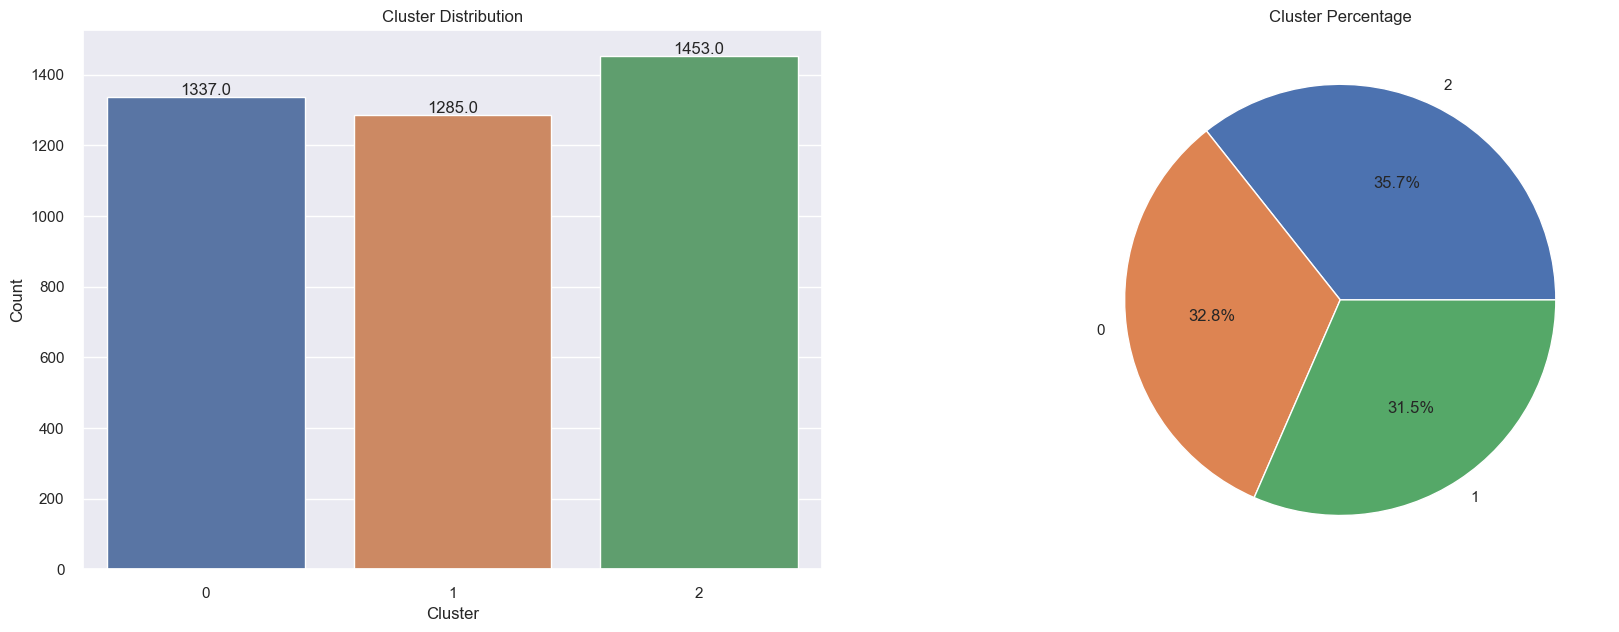

In [ ]:
# defining the figure size

plt.figure(figsize=(21, 7))

# showing count plot for cluster distribution

plt.subplot(1, 2, 1)
fig = sns.countplot(x='Cluster', data=df_cln)
for p in fig.patches:
    fig.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')

# showing pie plot for cluster distribution percentage

plt.subplot(1, 2, 2)
plt.pie(df_cln['Cluster'].value_counts(), labels=df_cln['Cluster'].value_counts().index, autopct='%1.1f%%')
plt.title('Cluster Percentage')

plt.show()

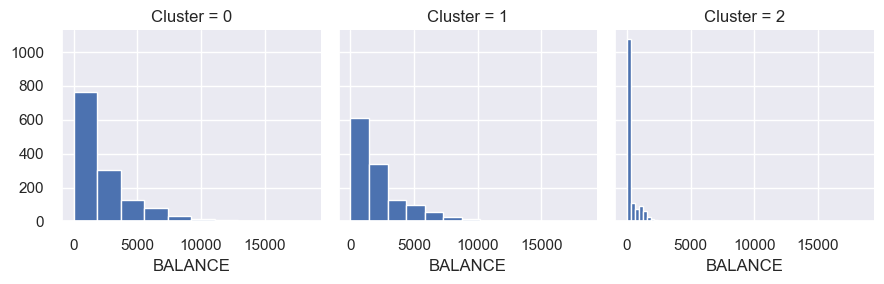

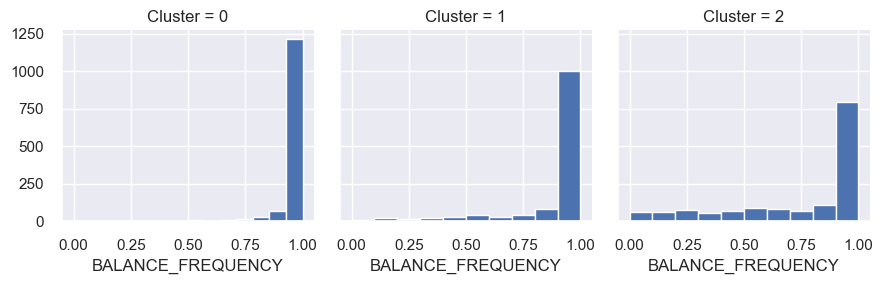

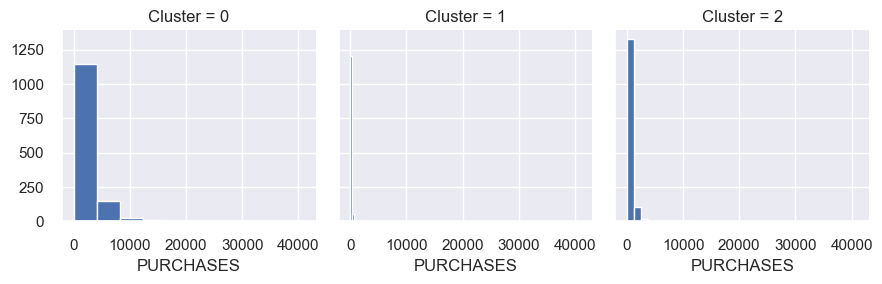

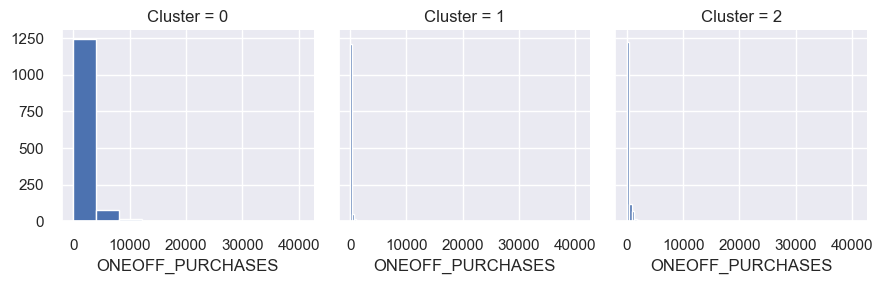

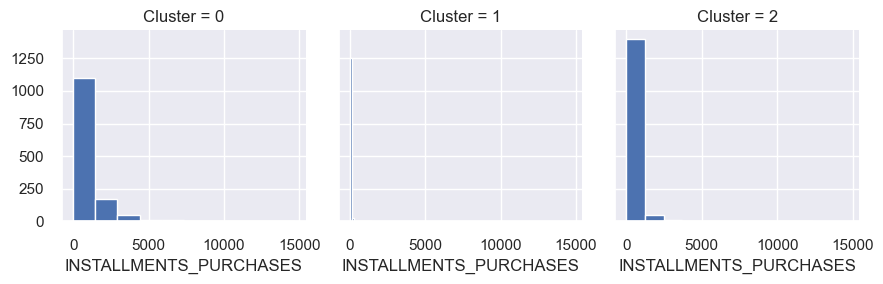

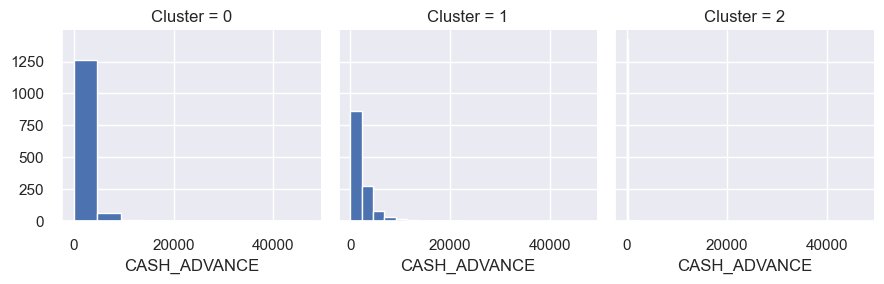

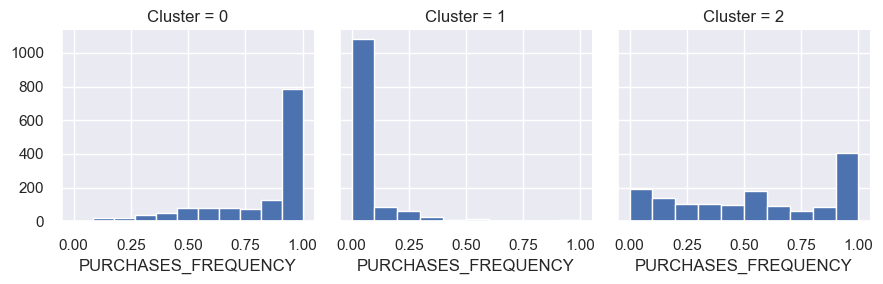

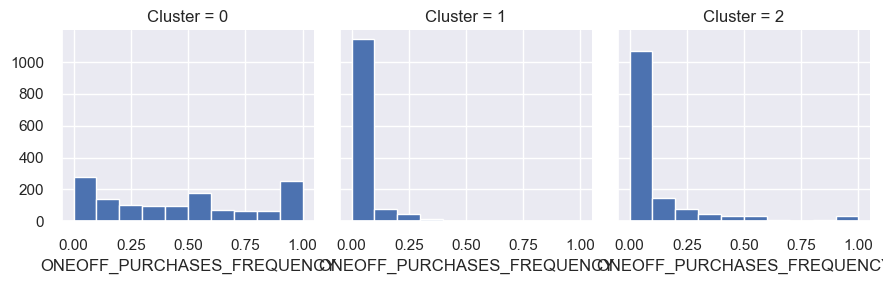

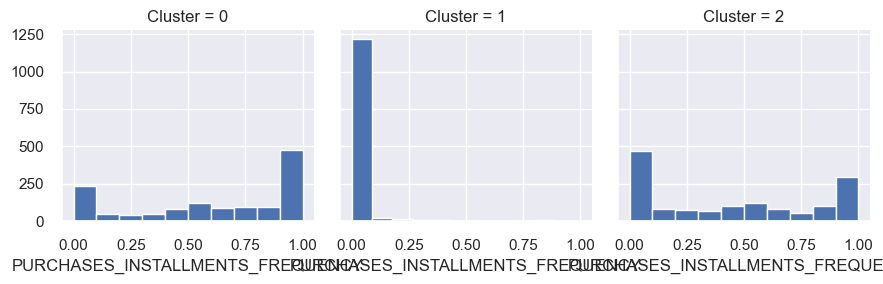

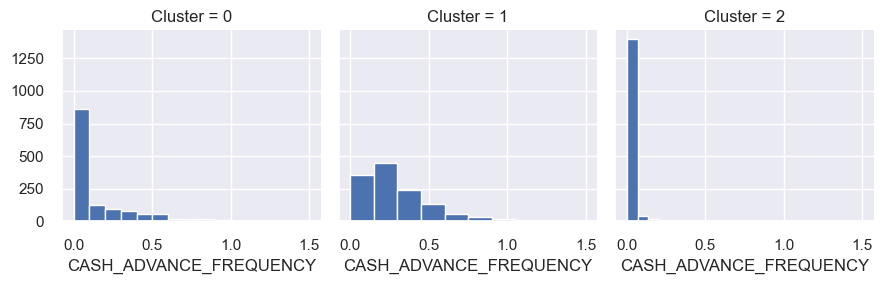

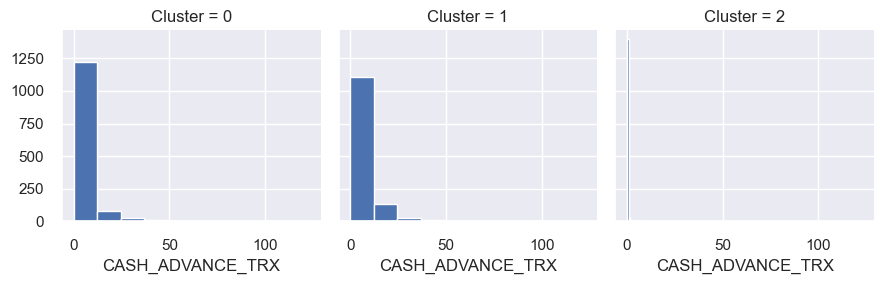

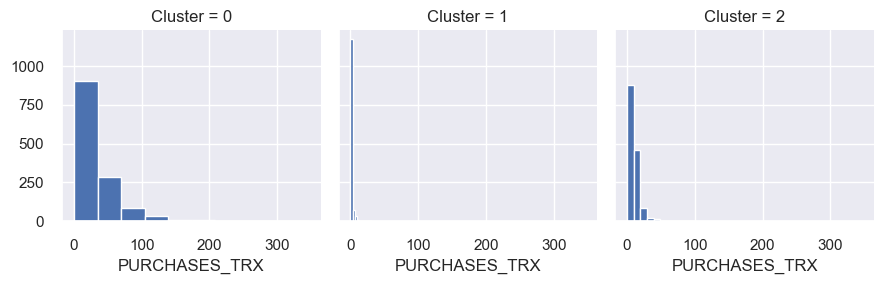

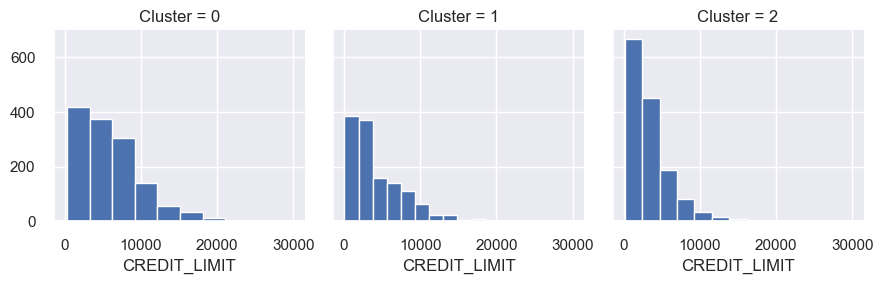

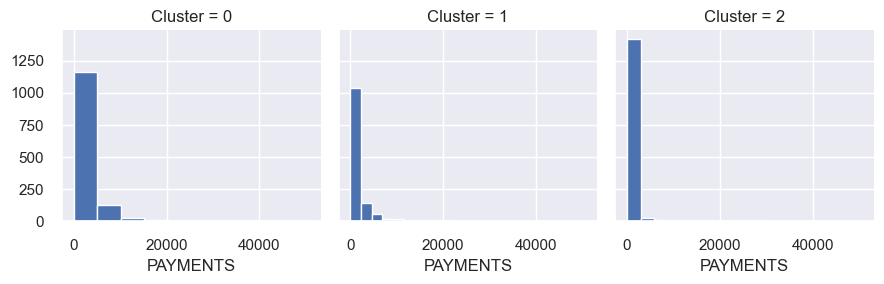

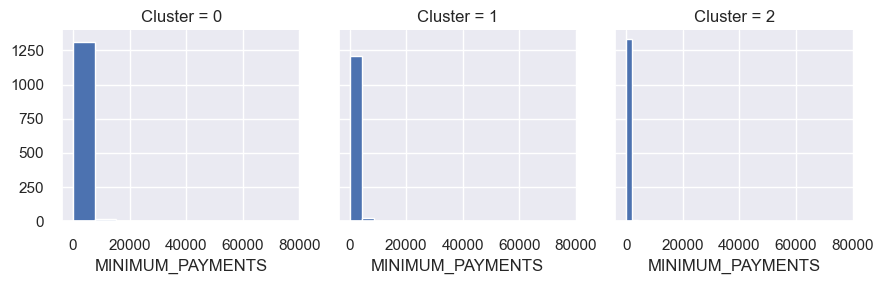

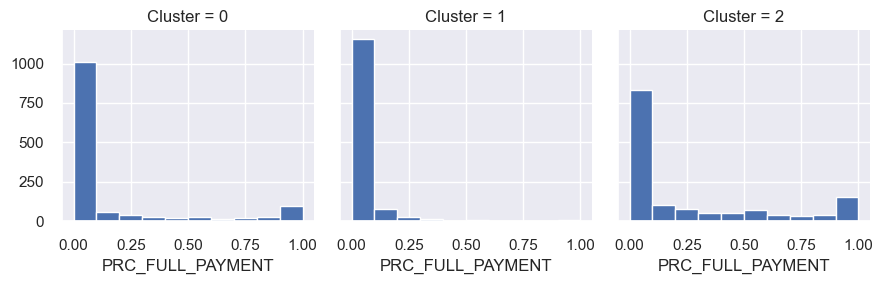

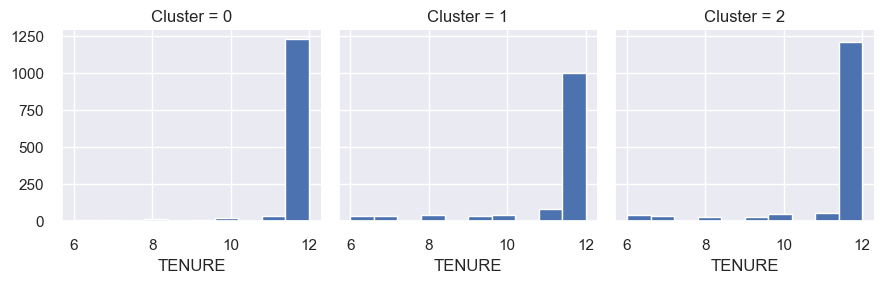

In [ ]:
# making loop for cluster analisys

for c in df_cln.drop(['Cluster'], axis = 1):
    grid= sns.FacetGrid(df_cln, col='Cluster')
    grid.map(plt.hist, c)

Based on the depicted plots, it is evident that the distribution of the clusters exhibits a nearly balanced allocation, with cluster 0 accounting for 32.8% of the total, cluster 1 representing 31.5%, and cluster 2 encompassing 35.7% of the overall client.

Based on the table provided, we can assign aliases to each cluster to summarize their characteristics:

Cluster 0, known as <mark>Wealthy and Frequent Buyers</mark>, represents customers who have higher average balances and shop frequently. They make significant purchases, both in one-time payments and installment plans. They also use cash advances moderately. These customers have a higher frequency of purchases and more transactions, a substantial credit limit, and tend to make regular payments, although they may not pay off their full balances each time. They have been customers for a relatively long time, indicating loyalty.

Cluster 1, called <mark>Low-Spending and Cash Advance Users</mark>, includes customers with lower average balances and spend less frequently. They make smaller purchases, with fewer one-time and installment payments. However, they rely heavily on cash advances, resulting in more frequent cash advance transactions. These customers have a moderate credit limit, make relatively smaller payments, and rarely pay off their balances in full. Their tenure is similar to Cluster 0.

Cluster 2, named <mark>Moderate-Spending and Balanced Users</mark>, consists of customers with the lowest average balances and spending frequency among the clusters. They make moderate-sized purchases, with a balanced mix of one-time and installment payments. They use cash advances sparingly. These customers have a lower credit limit, make smaller payments, and have a higher rate of full payment compared to the other clusters. Their tenure is similar to Clusters 0 and 1.

## x. Model Saving

In this session, we will save all the needed files so that we can run the model inference flawlessly and efficiently.

In [ ]:
# save the model

pickle.dump(preprocess, open('preprocess.pkl', 'wb'))

pickle.dump(km, open('km_pred.pkl', 'wb'))

## xi. Model Inference

Model Inference will be done in the other notebook in order to avoid any errors, and it is an attempt to get as accurate results as possible.

## xii. Conclusion

During the <mark>Exploratory Data Analysis</mark> (EDA), it was observed that the dataset contains correlated features, which can be addressed through dimensionality reduction using Principal Component Analysis (PCA). The analysis revealed an average balance of approximately $1,600, with one outlier exceeding $18,500. A positive correlation between the balance and the number of purchases was identified. The violin plot demonstrated that most customers either refrain from purchases or engage in spending sprees, with a median value of 5. The purchases frequency column exhibited a symmetrical distribution without any missing values. Furthermore, a correlation between minimum payments and installment purchases was observed. The presence of outliers in the dataset will be further examined and appropriately handled.

To determine the <mark>optimal number of clusters</mark> for the clustering analysis, several methods were employed, including the <mark>elbow method, silhouette score method, and Davies-Bouldin index method</mark>. After thorough evaluation, it was determined that <mark>the most suitable cluster number for this case is k = 3</mark>. The resulting clusters displayed satisfactory outcomes, with no misassigned clients observed in the plot.

The <mark>distribution of the clusters</mark> in the dataset is reasonably <mark>balanced</mark>, with cluster 0 accounting for 32.8% of the total clients, cluster 1 representing 31.5%, and cluster 2 encompassing 35.7% of the overall customer base. <mark>Cluster 0</mark> represents <mark>affluent and frequent buyers</mark> who make substantial purchases. <mark>Cluster 1</mark> consists of <mark>customers who spend less and rely heavily on cash advances</mark>. <mark>Cluster 2</mark> comprises <mark>moderate spenders who maintain a balanced approach to their purchases</mark>.

Here are some <mark>recommendations</mark> that can be suggested to the company for each customer cluster:

**Cluster 0**
* Provide VIP treatment with exclusive benefits.
* Reward loyalty with personalized incentives and discounts.
* Offer upsell and cross-sell opportunities based on their preferences.
* Organize exclusive events to strengthen their loyalty.

**Cluster 1**
* Offer financial education and tools to improve their money management skills.
* Introduce alternatives to cash advances, such as short-term loans.
* Incentivize full payments with rewards and discounts.
* Create budget-friendly offers to cater to their spending habits.

**Cluster 2**
* Gradually increase their credit limits to reflect responsible financial management.
* Provide financial planning tools and resources.
* Reward full payment behavior with incentives.
* Offer personalized offers based on their preferences.

The <mark>K-Means algorithm</mark> possesses <mark>strengths</mark> such as its <mark>speed and efficiency</mark>, making it well-suited for real-time or near real-time applications that require prompt clustering results. It is particularly beneficial for unexpected projects that demand quick completion. However, a <mark>weakness</mark> of the algorithm lies in the <mark>challenge of determining the optimal value for k</mark>, which can be subjective and dependent on domain knowledge and iterative experimentation. Consequently, it is <mark>not recommended for beginners aiming to swiftly finish a project</mark>.

To <mark>improve</mark> the clustering process, it is advisable to implement <mark>automated techniques</mark>, such as the silhouette score or gap statistic, for selecting the optimal number of clusters. This approach reduces reliance on subjective judgment and minimizes the need for extensive domain knowledge and iterative experimentation. Additionally, <mark>involving domain experts</mark> with a deep understanding of the business context and dataset can provide valuable insights and guidance in determining an appropriate value for k. <mark>Exploring alternative clustering algorithms</mark>, such as DBSCAN, Agglomerative Hierarchical Clustering, or Gaussian Mixture Models (GMM), may also prove beneficial to better align with the dataset characteristics and business requirements. These enhancements aim to reduce subjectivity, leverage domain expertise, and enhance the effectiveness of the clustering approach.

____